# Run experiments for FeedForward networks, as a baseline comparison against AttentionModels

In [2]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

import time

env: TMPDIR=/tmp/temp


# Data processing (If re-running code, skip to load data)

In [82]:
# Load Tox21 data
import pandas as pd
import numpy as np
dataset_name="XY_Tox21_CDKPaDEL_processed.csv"
df=pd.read_csv(os.path.join("..", 
                            "..",
                            "rawdata", 
                            dataset_name))

label_columns=range(5,17) #12 Tox21 labels
data_columns=range(17,1504) #1487 CDK+PaDEL descriptors (after filtering)
id_columns=range(5)  

training_ind=np.where(np.isin(df['Type'], ['Training', 'Testing']))[0]
testing_ind=np.where(df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

X_train=df.iloc[training_ind, data_columns].values
X_test=df.iloc[testing_ind, data_columns].values
y_train=df.iloc[training_ind, label_columns]
y_test=df.iloc[testing_ind, label_columns]
train_id_df=df.iloc[training_ind, id_columns]
test_id_df=df.iloc[testing_ind, id_columns]



XY_Tox21_CDKPaDEL_processed.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


In [83]:
#Load tanimoto similarity

dataset_sim_name="XY_Tox21_CDKPaDEL_processed_tanimoto.csv"
df_sim=pd.read_csv(os.path.join("..", 
                                "..",
                                "rawdata", 
                                dataset_sim_name
                               ), 
                   index_col=0
                  )

sim_train_df=df_sim.iloc[training_ind, training_ind+len(id_columns)]
sim_test_df=df_sim.iloc[testing_ind, training_ind+len(id_columns)]

## Impute missing values (as most ML can't deal with missing feature values)
Retain features with only 1 missing value. Drop features with only 1 unique value. Do median imputation. 

In [84]:
def median_imputation(X_train, X_test):
    for col in range(len(X_train[0])):
        med=np.nanmedian(X_train[:,col])
        
        train_nanind=np.where(np.isnan(X_train[:,col]))[0]
        test_nanind=np.where(np.isnan(X_test[:,col]))[0]
        
        if len(train_nanind)>0:
            X_train[train_nanind,col]=med
        if len(test_nanind)>0:
            X_test[test_nanind,col]=med
    return X_train, X_test

def zero_imputation(y):
    for col in range(len(y[0])):
        nan_ind=np.where(np.isnan(y[:,col]))[0]
        if len(nan_ind)>0:
            y[nan_ind,col]=0
    return y
        

In [85]:
retain_feat_ind=np.where(np.sum(np.isnan(X_train),axis=0)<2)[0]

X_train, X_test=median_imputation(X_train[:, retain_feat_ind], X_test[:, retain_feat_ind])



In [86]:
# y_train_impute=zero_imputation(y_train.values)
# y_test_impute=zero_imputation(y_test.values)

## Check for feature correlations

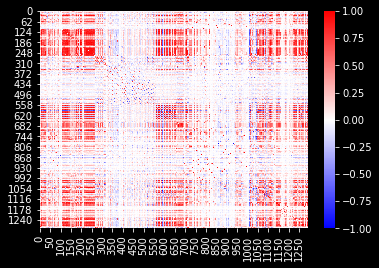

In [87]:
#Remove features that are almost identical to each other (R>0.95)
from scipy.stats import pearsonr
from itertools import combinations
m=X_train.shape[1]
R_mat=np.empty((m,m))
for (i,j) in combinations(range(m), 2):
    r=pearsonr(X_train[:,i], X_train[:,j])
    R_mat[i,j]=r[0]
    R_mat[j,i]=r[0]
for i in range(m):
    R_mat[i,i]=0.    
    
import seaborn as sns
ax= sns.heatmap(R_mat, center=0, cmap='bwr')

In [88]:
R_mat=np.nan_to_num(R_mat, nan=1.)

arr=pd.Series(np.abs(R_mat.flatten()))

print(f"{np.count_nonzero(arr==1)} comparisons with R=1.00")
print(f"{np.count_nonzero(arr>0.95)} comparisons with R>0.95")

136 comparisons with R=1.00
6948 comparisons with R>0.95


In [89]:
# arr=np.where(R_mat==1.)

def split_ind(arr):
    # Given 2D array of pairs of indices, return the lowest index of connected groups of indices
    retain_list=[]
    omit_list=[]
    for i in range(len(arr[0])):
        head, tail=arr[0][i], arr[1][i]
        if head in retain_list:
            omit_list=np.append(omit_list,tail)
        elif tail in retain_list:
            omit_list=np.append(omit_list,head)
        else:
            retain_list=np.append(retain_list, head)
            omit_list=np.append(omit_list,tail)
        retain_list=np.setdiff1d(retain_list, omit_list)
        omit_list=np.unique(omit_list)
    return retain_list, omit_list
    

In [90]:
retain_list2, omit_list2=split_ind(np.where(np.abs(R_mat)>0.99))

In [91]:
len(omit_list2)

345

We omit comparisons with R>0.95

In [92]:
filtered_features=np.setdiff1d(range(m), omit_list2)
X_train_filtered=X_train[:,filtered_features]
X_test_filtered=X_test[:,filtered_features]

print(f"{len(filtered_features)} out of {m} features retained.")

945 out of 1290 features retained.


## Learn Fweights (by fitting COSA model)

In [ ]:
from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=100,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=-1
                    )
cosa_mdl.fit(X_train_filtered)

Starting on outer iteration 1; beta/eta:0.220
Wchange:0.598, Crit:-401030.862
Wchange:0.142, Crit:-394108.120
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.061, Crit:-392041.416
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.032, Crit:-391472.136
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280


In [ ]:
cosa_mdl.fit_OOS(X_test_filtered)

In [ ]:
# Fweights=cosa_mdl.output_Fweight()
# cosa_dist=cosa_mdl.output_Dmat()

## Save processed data

In [96]:
save_folder=os.path.join("processed_data"
                        )
new_data_columns=np.array(data_columns)[filtered_features]

processed_df_columns=np.concatenate([id_columns, 
                                     label_columns, 
                                     new_data_columns
                                    ])
processed_df=df
processed_df.iloc[training_ind, new_data_columns]=X_train_filtered
processed_df.iloc[testing_ind, new_data_columns]=X_test_filtered
processed_df=processed_df.iloc[:, processed_df_columns]

processed_df.to_csv(os.path.join(
    save_folder,
    "XY_Tox21_CDKPaDEL_processedFiltered.csv"
))

In [ ]:
# # Save Fweights
import pandas as pd
Fweights=cosa_mdl.output_Fweight()
df= pd.DataFrame(Fweights)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_train.csv"), 
          index=False)

# import pandas as pd
# Fweights=pd.read_csv("Tox21_Fweights_train.txt")
# cosa_mdl.Fweight=Fweights.values

cosa_dist=cosa_mdl.output_Dmat()
df=pd.DataFrame(cosa_dist)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_train.csv"),
          index=False)

In [ ]:
Fweights_OOS=cosa_mdl.output_Fweight(OOS=True)
df= pd.DataFrame(Fweights_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_test.csv"), 
          index=False)

cosa_dist_OOS=cosa_mdl.output_Dmat(OOS=True)
df=pd.DataFrame(cosa_dist_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_test.csv"),
          index=False)

# Load processed data 
To be updated again when COSA fitting is completed

In [3]:
load_folder=os.path.join("processed_data"
                        )
dataset_name="XY_Tox21_CDKPaDEL_processedFiltered.csv"
load_df=pd.read_csv(os.path.join(load_folder, 
                                 dataset_name
                                ), 
                    index_col=0
                   )

label_columns=range(5,17) #12 Tox21 labels
data_columns=range(17,load_df.shape[1]) #945/1487 filtered CDK+PaDEL descriptors (after filtering)
id_columns=range(5)  

training_ind=np.where(np.isin(load_df['Type'], ['Training', 'Testing']))[0]
testing_ind=np.where(load_df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

X_train=load_df.iloc[training_ind, data_columns].values
X_test=load_df.iloc[testing_ind, data_columns].values
y_train=load_df.iloc[training_ind, label_columns]
y_test=load_df.iloc[testing_ind, label_columns]
train_id_df=load_df.iloc[training_ind, id_columns]
test_id_df=load_df.iloc[testing_ind, id_columns]


Fweights_df=pd.read_csv(os.path.join(load_folder, 
                                     "Tox21_CDKPaDEL_Fweights_train.csv"
                                    ))
Fweights_train=Fweights_df[load_df.columns[data_columns]].values

Fweights_OOS_df=pd.read_csv(os.path.join(load_folder,
                                          "Tox21_CDKPaDEL_Fweights_test.csv"
                                         ))
Fweights_test=Fweights_OOS_df[load_df.columns[data_columns]].values

XY_Tox21_CDKPaDEL_processedFiltered.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


# Train deep feed forward networks

## Model set-up

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
#Updated 6th Jan 2021 (Edited Line 71 to Line 72. Reduce_mean instead of mean, to preserve the required rank)

from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
epsilon=K.epsilon

def get_weights_dicts(Y):
    weights_dicts=[]
    for j in range(Y.shape[1]):
        weight_zero, weight_one = _get_label_weights(Y[:,j])
        d={'weight_zero':weight_zero,
           'weight_one':weight_one
          }
        weights_dicts.append(d)
    return weights_dicts
def _get_label_weights(y):
    #Get label weights for majority and minority class using the following:
        #major_weight=n/(n_major*2)
        #minor_weight=n*(n_major/n_minor)/(n_major*2)
        #NaN weights are set to zero
    y1=y[~np.isnan(y)]
    n=len(y1)
    n_zero=np.count_nonzero(np.isclose(y1,0))
    n_one=np.count_nonzero(np.isclose(y1,1))
    if n_zero>n_one:
        weight_zero=n/(n_zero*2)
        weight_one=n*(n_zero/n_one)/(n_zero*2)
    else:
        weight_zero=n*(n_one/n_zero)/(n_one*2)
        weight_one=n/(n_one*2)
    return weight_zero, weight_one    

class BinaryCrossEntropyIgnoreNaN(tf.keras.losses.Loss):
    def __init__(self, weights_dicts=None, axis=0, **kwargs):
        super(BinaryCrossEntropyIgnoreNaN, self).__init__(**kwargs)
        self.weights_dicts=weights_dicts
        self.axis=axis        

    def __call__(self, target, output, sample_weight=None):
        #Binary cross entropy that ignores Nan and replaces with mini-batch Nan with 0
        #modified from tf.python.keras.backend.binary_crossentropy
        
        ##NEED TO TEST THIS CODE MORE THOROUGHLY
        target=tf.convert_to_tensor(target)
        output=tf.convert_to_tensor(output)
        if len(target.shape)==1:
            target=tf.expand_dims(target, 1)
            output=tf.expand_dims(output, 1)
        epsilon_ = tf.constant(epsilon(), dtype=output.dtype.base_dtype)
        output=tf.clip_by_value(output, epsilon_, 1. - epsilon_)

        #Compute cross entropy from probabilities
        bce=target * tf.math.log(output+epsilon_)
        bce+=(1-target)* tf.math.log(1-output+epsilon_)

        bce=tf.where(tf.math.is_nan(-bce), epsilon(), -bce)
        if self.weights_dicts is not None:
            sample_weight=tf.cast(tf.where(target==0.,1.,0.)*[self.weights_dicts[i]['weight_zero'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            sample_weight+=tf.cast(tf.where(target==1., 1., 0.)*[self.weights_dicts[i]['weight_one'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            bce=tf.multiply(sample_weight, bce)
#         return tf.keras.backend.mean(bce, axis=self.axis)  
        return tf.math.reduce_mean(bce)

    def call(self, target, output, sample_weight=None):
        return self(target, output, sample_weight=None)

## Load single label

In [11]:
label='NR-AR'

train_inds=~np.isnan(y_train[label])
test_inds=~np.isnan(y_test[label])

train_data=X_train[train_inds,:]
train_targets=y_train[label][train_inds].astype(np.float32)
test_data=X_test[test_inds,:]
test_targets=y_test[label][test_inds].astype(np.float32)
#train_Fweights
#test_Fweights

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))


In [ ]:
#Temporarily use this file first. 
#There are fewer chemicals in this file

In [ ]:
load_folder=os.path.join("ARE_v2"
                        )

#Load Tox21 processed data (ARE)
processed_data_df=pd.read_csv(os.path.join(load_folder, 
                                           "Tox21_CDKPaDEL_processedData_AREv2.csv"
                                          ), index_col=0
                             )
label_ind=processed_data_df.shape[1]-2 

feat_ind=range(processed_data_df.shape[1]-2)

X_train_ARE2=(processed_data_df.query("Type=='Training'")
             .iloc[:,feat_ind]).values
X_test_ARE2=(processed_data_df.query("Type=='Testing'")
            .iloc[:,feat_ind]).values
y_train_ARE2=(processed_data_df.query("Type=='Training'")
             .iloc[:,label_ind]).values
y_test_ARE2=(processed_data_df.query("Type=='Testing'")
            .iloc[:,label_ind]).values

#Load COSA feature weights and distances for Tox21 processed data (ARE)
Fweights_train_df=pd.read_csv(os.path.join(load_folder,
                                     "Tox21_CDKPaDEL_Fweights_ARE_train2.csv",                                 
                                    )
                       )
Fweights_train=Fweights_train_df.iloc[:,:-1].values


Fweights_test_df=pd.read_csv(os.path.join(load_folder, 
                                          "Tox21_CDKPaDEL_FweightsOOS_ARE_test2.csv"
                                         ))
Fweights_test=Fweights_test_df.iloc[:,:-1]

# temp_ind=Fweights_df['ind']




## Model architecture

In [12]:
# n_feat = train_data.shape[1]
# n_attention = 20 #Reduced from 20 to 10. 10 works better
# n_attention_hidden=20
# n_attention_out=1
# n_concat_hidden=2048
# n_hidden1 =512
# n_hidden2 = 64 #Added 2nd hidden layer
# momentum=0.8
# learning_rate=0.001

# n_batch=32

n_feat = train_tensor.shape[1]
n_attention = 20 #Reduced from 20 to 10. 10 works better
n_attention_hidden=20
n_attention_out=1
n_concat_hidden=4096
n_hidden1 =1024
n_hidden2 = 128 #Added 2nd hidden layer
momentum=0.8
learning_rate=0.001

n_batch=32

save_folder=os.path.join(time.strftime("%y%m%d_TrainingDeep",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "Dense_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: '210120_TrainingDeep'
[WinError 183] Cannot create a file when that file already exists: '210120_TrainingDeep\\Dense_NR-AR'


In [147]:
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1

np.random.seed(0)

dense_model=Sequential()
dense_model.add(Dense(n_attention*n_attention_hidden, 
                      activation="gelu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5),
#                  input_shape=(n_feat,),
                ))
dense_model.add(Dropout(0.1))
dense_model.add(Dense(n_attention*n_feat, activation="gelu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5),
                     ))
# dense_model.add(LeakyReLU())
dense_model.add(Dense(n_concat_hidden, activation="gelu",  
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5),   
#                       activity_regularizer=l1(1E-5)                      
                     ))
# dense_model.add(LeakyReLU())
dense_model.add(Dropout(0.1))
dense_model.add(Dense(n_hidden1, activation="gelu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5),
                     ))
# dense_model.add(LeakyReLU())
dense_model.add(Dropout(0.1))
dense_model.add(Dense(n_hidden2, activation="gelu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5),
                     ))
# dense_model.add(LeakyReLU())
dense_model.add(Dropout(0.1))
dense_model.add(Dense(1, activation="sigmoid",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l1(1E-5),
                      bias_regularizer=l1(1E-5)
                     ))

loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

dense_model.compile(tf.optimizers.Adam(learning_rate=learning_rate,),
                   loss=loss_fn, 
                    metrics=['accuracy', 'AUC'],
              )


In [19]:
from tensorflow.keras import callbacks

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)


n_epoch=100

dense_model.fit(train_data,
                train_targets,
                epochs=n_epoch, 
                batch_size=n_batch, 
                validation_data=(test_data, test_targets),
                verbose=2,
                shuffle=True,
                callbacks=[csvlogger_callback,
                           cp_callback
                          ])

Epoch 1/100
292/292 - 8s - loss: 3.6190 - accuracy: 0.7750 - auc: 0.7640 - val_loss: 1.7328 - val_accuracy: 0.9009 - val_auc: 0.6670

Epoch 00001: val_auc improved from -inf to 0.66704, saving model to 210120_TrainingDeep\Dense_NR-AR
Epoch 2/100
292/292 - 6s - loss: 1.2129 - accuracy: 0.9214 - auc: 0.7988 - val_loss: 0.8358 - val_accuracy: 0.9635 - val_auc: 0.6767

Epoch 00002: val_auc improved from 0.66704 to 0.67673, saving model to 210120_TrainingDeep\Dense_NR-AR
Epoch 3/100
292/292 - 6s - loss: 0.8040 - accuracy: 0.8857 - auc: 0.8220 - val_loss: 0.6600 - val_accuracy: 0.9200 - val_auc: 0.6929

Epoch 00003: val_auc improved from 0.67673 to 0.69287, saving model to 210120_TrainingDeep\Dense_NR-AR
Epoch 4/100
292/292 - 7s - loss: 0.6567 - accuracy: 0.8992 - auc: 0.8352 - val_loss: 0.5816 - val_accuracy: 0.9496 - val_auc: 0.7131

Epoch 00004: val_auc improved from 0.69287 to 0.71307, saving model to 210120_TrainingDeep\Dense_NR-AR
Epoch 5/100
292/292 - 7s - loss: 0.6917 - accuracy: 0.8

Epoch 43/100
292/292 - 6s - loss: 0.5706 - accuracy: 0.9078 - auc: 0.8721 - val_loss: 0.5181 - val_accuracy: 0.9374 - val_auc: 0.7285

Epoch 00043: val_auc did not improve from 0.79204
Epoch 44/100
292/292 - 6s - loss: 0.5129 - accuracy: 0.9098 - auc: 0.8751 - val_loss: 0.6038 - val_accuracy: 0.8365 - val_auc: 0.7448

Epoch 00044: val_auc did not improve from 0.79204
Epoch 45/100
292/292 - 6s - loss: 0.5392 - accuracy: 0.9018 - auc: 0.8772 - val_loss: 0.5358 - val_accuracy: 0.9113 - val_auc: 0.7388

Epoch 00045: val_auc did not improve from 0.79204
Epoch 46/100
292/292 - 7s - loss: 0.6074 - accuracy: 0.8923 - auc: 0.8663 - val_loss: 1.3972 - val_accuracy: 0.8817 - val_auc: 0.7557

Epoch 00046: val_auc did not improve from 0.79204
Epoch 47/100
292/292 - 7s - loss: 0.9042 - accuracy: 0.8627 - auc: 0.8415 - val_loss: 0.6388 - val_accuracy: 0.9687 - val_auc: 0.6503

Epoch 00047: val_auc did not improve from 0.79204
Epoch 48/100
292/292 - 7s - loss: 0.6723 - accuracy: 0.9099 - auc: 0.8713 -

292/292 - 6s - loss: 0.5357 - accuracy: 0.8950 - auc: 0.8990 - val_loss: 0.5362 - val_accuracy: 0.8870 - val_auc: 0.7420

Epoch 00087: val_auc did not improve from 0.84488
Epoch 88/100
292/292 - 6s - loss: 0.5020 - accuracy: 0.9074 - auc: 0.9066 - val_loss: 0.6150 - val_accuracy: 0.9496 - val_auc: 0.7490

Epoch 00088: val_auc did not improve from 0.84488
Epoch 89/100
292/292 - 6s - loss: 0.5532 - accuracy: 0.9305 - auc: 0.8829 - val_loss: 0.5763 - val_accuracy: 0.9374 - val_auc: 0.7509

Epoch 00089: val_auc did not improve from 0.84488
Epoch 90/100
292/292 - 6s - loss: 0.5193 - accuracy: 0.9069 - auc: 0.9118 - val_loss: 0.5677 - val_accuracy: 0.9391 - val_auc: 0.7297

Epoch 00090: val_auc did not improve from 0.84488
Epoch 91/100
292/292 - 7s - loss: 0.5012 - accuracy: 0.9140 - auc: 0.9178 - val_loss: 0.5172 - val_accuracy: 0.9548 - val_auc: 0.7080

Epoch 00091: val_auc did not improve from 0.84488
Epoch 92/100
292/292 - 7s - loss: 0.7062 - accuracy: 0.9060 - auc: 0.9017 - val_loss: 0.

### Loop training for all single-labels

In [66]:
def initialize_model(weights_dicts,
                     n_attention=n_attention, 
                     n_attention_hidden=n_attention_hidden, 
                     n_feat=n_feat,
                     n_concat_hidden=n_concat_hidden,
                     n_hidden1=n_hidden1, 
                     n_hidden2=n_hidden2,
                    ):
    dense_model=Sequential()
    dense_model.add(Dense(n_attention*n_attention_hidden, 
                          activation="gelu",
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5),
    #                  input_shape=(n_feat,),
                    ))
    dense_model.add(Dense(n_attention*n_feat*n_attention_out, activation="gelu",
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5),
                         ))
    # dense_model.add(LeakyReLU())
    dense_model.add(Dense(n_concat_hidden, activation="gelu",  
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5),   
    #                       activity_regularizer=l1(1E-5)                      
                         ))
    # dense_model.add(LeakyReLU())
    dense_model.add(Dropout(0.1))
    dense_model.add(Dense(n_hidden1, activation="gelu",
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5),
                         ))
    # dense_model.add(LeakyReLU())
    dense_model.add(Dropout(0.1))
    dense_model.add(Dense(n_hidden2, activation="gelu",
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5),
                         ))
    # dense_model.add(LeakyReLU())
    dense_model.add(Dropout(0.1))
    dense_model.add(Dense(1, activation="sigmoid",
                          kernel_initializer=VarianceScaling(),
                          kernel_regularizer=l1(1E-5),
                          bias_regularizer=l1(1E-5)
                         ))

    loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

    dense_model.compile(tf.optimizers.Adam(learning_rate=learning_rate,),
                       loss=loss_fn, 
                        metrics=['accuracy', 'AUC'],
                  )
    return dense_model

In [68]:
# Repeat above for all labels
n_epoch = 100
tmp_file = os.path.join(save_folder,
"{}_Dense_tmpfile.csv".format(time.strftime("%y%m%d", time.localtime()),
                     ))

with open(tmp_file, 'w') as tmpfile:
    tmpfile.write(",".join(["Label", "Best_AUC", "/n"]))

for label in y_train.columns:
    # Load data
    train_inds = ~np.isnan(y_train[label])
    test_inds = ~np.isnan(y_test[label])

    train_data = X_train[train_inds, :]
    train_targets = y_train[label][train_inds].astype(np.float32)
    test_data = X_test[test_inds, :]
    test_targets = y_test[label][test_inds].astype(np.float32)
    # train_Fweights
    # test_Fweights

    weights_dicts = get_weights_dicts(np.expand_dims(train_targets, 1))

    # Set save folders
    checkpoint_path = os.path.join(save_folder, "{}_Dense_{}".format(time.strftime("%y%m%d", time.localtime()),
                     label)
                                  )
    try:
        os.mkdir(checkpoint_path)
    except OSError as error:
        print(error)

    np.random.seed(0)

    dense_model_=initialize_model(weights_dicts = weights_dicts)


    cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 monitor = 'val_auc',
                                                 mode = 'max',
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 verbose = 1)

    csv_filename=os.path.join(checkpoint_path, "training_log.csv")
    csvlogger_callback=tf.keras.callbacks.CSVLogger(
        filename = csv_filename, append = True)

    dense_model_.fit(train_data,
                    train_targets,
                    epochs=n_epoch, 
                    batch_size=n_batch, 
                    validation_data=(test_data, test_targets),
                    verbose=2,
                    shuffle=True,
                    callbacks=[csvlogger_callback,
                               cp_callback
                              ])
    
    with open(tmp_file, 'a') as tmpfile:
        tmpfile.write(",".join([label, str(cp_callback.best)+"/n"]))
    
    del dense_model_

[WinError 183] Cannot create a file when that file already exists: '210120_TrainingDeep\\210120_Dense_NR-AR'
Epoch 1/100
292/292 - 9s - loss: 4.3231 - accuracy: 0.7380 - auc: 0.7148 - val_loss: 2.4061 - val_accuracy: 0.9565 - val_auc: 0.6796

Epoch 00001: val_auc improved from -inf to 0.67962, saving model to 210120_TrainingDeep\210120_Dense_NR-AR
Epoch 2/100
292/292 - 7s - loss: 1.7785 - accuracy: 0.8925 - auc: 0.8014 - val_loss: 1.2416 - val_accuracy: 0.9722 - val_auc: 0.7288

Epoch 00002: val_auc improved from 0.67962 to 0.72876, saving model to 210120_TrainingDeep\210120_Dense_NR-AR
Epoch 3/100
292/292 - 7s - loss: 1.0809 - accuracy: 0.9184 - auc: 0.8234 - val_loss: 0.8635 - val_accuracy: 0.9722 - val_auc: 0.7126

Epoch 00003: val_auc did not improve from 0.72876
Epoch 4/100
292/292 - 7s - loss: 0.8160 - accuracy: 0.9388 - auc: 0.8261 - val_loss: 0.7276 - val_accuracy: 0.9722 - val_auc: 0.7349

Epoch 00004: val_auc improved from 0.72876 to 0.73490, saving model to 210120_TrainingDe


Epoch 00042: val_auc did not improve from 0.77442
Epoch 43/100
292/292 - 7s - loss: 0.4521 - accuracy: 0.8786 - auc: 0.9120 - val_loss: 0.5806 - val_accuracy: 0.6957 - val_auc: 0.6780

Epoch 00043: val_auc did not improve from 0.77442
Epoch 44/100
292/292 - 7s - loss: 0.4348 - accuracy: 0.8857 - auc: 0.9145 - val_loss: 0.5047 - val_accuracy: 0.8017 - val_auc: 0.7602

Epoch 00044: val_auc did not improve from 0.77442
Epoch 45/100
292/292 - 7s - loss: 0.4260 - accuracy: 0.8721 - auc: 0.9226 - val_loss: 0.5671 - val_accuracy: 0.9026 - val_auc: 0.6089

Epoch 00045: val_auc did not improve from 0.77442
Epoch 46/100
292/292 - 7s - loss: 0.4301 - accuracy: 0.8806 - auc: 0.9190 - val_loss: 0.5174 - val_accuracy: 0.8609 - val_auc: 0.6955

Epoch 00046: val_auc did not improve from 0.77442
Epoch 47/100
292/292 - 7s - loss: 0.4080 - accuracy: 0.8740 - auc: 0.9321 - val_loss: 0.6631 - val_accuracy: 0.6748 - val_auc: 0.6881

Epoch 00047: val_auc did not improve from 0.77442
Epoch 48/100
292/292 - 7


Epoch 00086: val_auc did not improve from 0.79744
Epoch 87/100
292/292 - 7s - loss: 0.8122 - accuracy: 0.8896 - auc: 0.7853 - val_loss: 0.7152 - val_accuracy: 0.8991 - val_auc: 0.7308

Epoch 00087: val_auc did not improve from 0.79744
Epoch 88/100
292/292 - 7s - loss: 0.9021 - accuracy: 0.9099 - auc: 0.8053 - val_loss: 0.9310 - val_accuracy: 0.9287 - val_auc: 0.7395

Epoch 00088: val_auc did not improve from 0.79744
Epoch 89/100
292/292 - 7s - loss: 0.8585 - accuracy: 0.9093 - auc: 0.8303 - val_loss: 0.6901 - val_accuracy: 0.9235 - val_auc: 0.6002

Epoch 00089: val_auc did not improve from 0.79744
Epoch 90/100
292/292 - 7s - loss: 0.8519 - accuracy: 0.9454 - auc: 0.4984 - val_loss: 0.6183 - val_accuracy: 0.9791 - val_auc: 0.5000

Epoch 00090: val_auc did not improve from 0.79744
Epoch 91/100
292/292 - 6s - loss: 0.6907 - accuracy: 0.9267 - auc: 0.8006 - val_loss: 0.5488 - val_accuracy: 0.9583 - val_auc: 0.7408

Epoch 00091: val_auc did not improve from 0.79744
Epoch 92/100
292/292 - 7


Epoch 00027: val_auc did not improve from 0.90153
Epoch 28/100
257/257 - 6s - loss: 0.4145 - accuracy: 0.8493 - auc: 0.9306 - val_loss: 0.5497 - val_accuracy: 0.8138 - val_auc: 0.8921

Epoch 00028: val_auc did not improve from 0.90153
Epoch 29/100
257/257 - 6s - loss: 0.4324 - accuracy: 0.8328 - auc: 0.9259 - val_loss: 0.6034 - val_accuracy: 0.8641 - val_auc: 0.8904

Epoch 00029: val_auc did not improve from 0.90153
Epoch 30/100
257/257 - 6s - loss: 0.4255 - accuracy: 0.8421 - auc: 0.9281 - val_loss: 0.5127 - val_accuracy: 0.7903 - val_auc: 0.8847

Epoch 00030: val_auc did not improve from 0.90153
Epoch 31/100
257/257 - 6s - loss: 0.4292 - accuracy: 0.8474 - auc: 0.9304 - val_loss: 0.5040 - val_accuracy: 0.8188 - val_auc: 0.8964

Epoch 00031: val_auc did not improve from 0.90153
Epoch 32/100
257/257 - 6s - loss: 0.4382 - accuracy: 0.8389 - auc: 0.9235 - val_loss: 0.5436 - val_accuracy: 0.8389 - val_auc: 0.8880

Epoch 00032: val_auc did not improve from 0.90153
Epoch 33/100
257/257 - 6

257/257 - 6s - loss: 0.3294 - accuracy: 0.8765 - auc: 0.9581 - val_loss: 0.6565 - val_accuracy: 0.7483 - val_auc: 0.8643

Epoch 00072: val_auc did not improve from 0.90153
Epoch 73/100
257/257 - 6s - loss: 0.6633 - accuracy: 0.7836 - auc: 0.9188 - val_loss: 0.9384 - val_accuracy: 0.7886 - val_auc: 0.8822

Epoch 00073: val_auc did not improve from 0.90153
Epoch 74/100
257/257 - 6s - loss: 0.4929 - accuracy: 0.8556 - auc: 0.9503 - val_loss: 0.6608 - val_accuracy: 0.7852 - val_auc: 0.8737

Epoch 00074: val_auc did not improve from 0.90153
Epoch 75/100
257/257 - 6s - loss: 0.3768 - accuracy: 0.8727 - auc: 0.9599 - val_loss: 0.6288 - val_accuracy: 0.7785 - val_auc: 0.9030

Epoch 00075: val_auc improved from 0.90153 to 0.90305, saving model to 210120_TrainingDeep\210120_Dense_NR-AhR
Epoch 76/100
257/257 - 6s - loss: 0.3498 - accuracy: 0.8740 - auc: 0.9609 - val_loss: 0.7538 - val_accuracy: 0.7752 - val_auc: 0.8811

Epoch 00076: val_auc did not improve from 0.90305
Epoch 77/100
257/257 - 6s -


Epoch 00014: val_auc improved from 0.73942 to 0.79122, saving model to 210120_TrainingDeep\210120_Dense_NR-AR-LBD
Epoch 15/100
269/269 - 6s - loss: 0.4574 - accuracy: 0.9443 - auc: 0.8886 - val_loss: 0.5655 - val_accuracy: 0.9807 - val_auc: 0.7143

Epoch 00015: val_auc did not improve from 0.79122
Epoch 16/100
269/269 - 6s - loss: 0.4339 - accuracy: 0.9481 - auc: 0.9066 - val_loss: 0.4595 - val_accuracy: 0.9508 - val_auc: 0.7486

Epoch 00016: val_auc did not improve from 0.79122
Epoch 17/100
269/269 - 6s - loss: 0.4561 - accuracy: 0.9272 - auc: 0.9042 - val_loss: 0.5736 - val_accuracy: 0.9772 - val_auc: 0.7367

Epoch 00017: val_auc did not improve from 0.79122
Epoch 18/100
269/269 - 6s - loss: 0.4461 - accuracy: 0.9574 - auc: 0.9050 - val_loss: 0.4533 - val_accuracy: 0.9578 - val_auc: 0.8230

Epoch 00018: val_auc improved from 0.79122 to 0.82297, saving model to 210120_TrainingDeep\210120_Dense_NR-AR-LBD
Epoch 19/100
269/269 - 6s - loss: 0.4256 - accuracy: 0.9585 - auc: 0.9140 - val_l

269/269 - 6s - loss: 0.5450 - accuracy: 0.9538 - auc: 0.9436 - val_loss: 0.5591 - val_accuracy: 0.8840 - val_auc: 0.7311

Epoch 00058: val_auc did not improve from 0.85684
Epoch 59/100
269/269 - 6s - loss: 0.4090 - accuracy: 0.9519 - auc: 0.9372 - val_loss: 0.6067 - val_accuracy: 0.9455 - val_auc: 0.7058

Epoch 00059: val_auc did not improve from 0.85684
Epoch 60/100
269/269 - 6s - loss: 0.5192 - accuracy: 0.9365 - auc: 0.9188 - val_loss: 0.6096 - val_accuracy: 0.9561 - val_auc: 0.6058

Epoch 00060: val_auc did not improve from 0.85684
Epoch 61/100
269/269 - 6s - loss: 0.4017 - accuracy: 0.9614 - auc: 0.9390 - val_loss: 0.5753 - val_accuracy: 0.9613 - val_auc: 0.5827

Epoch 00061: val_auc did not improve from 0.85684
Epoch 62/100
269/269 - 6s - loss: 0.3990 - accuracy: 0.9532 - auc: 0.9434 - val_loss: 0.5415 - val_accuracy: 0.9578 - val_auc: 0.6639

Epoch 00062: val_auc did not improve from 0.85684
Epoch 63/100
269/269 - 6s - loss: 0.3762 - accuracy: 0.9581 - auc: 0.9429 - val_loss: 0.

242/242 - 6s - loss: 0.9812 - accuracy: 0.7663 - auc: 0.7317 - val_loss: 0.7673 - val_accuracy: 0.6410 - val_auc: 0.7871

Epoch 00002: val_auc improved from 0.75407 to 0.78707, saving model to 210120_TrainingDeep\210120_Dense_NR-ER
Epoch 3/100
242/242 - 5s - loss: 0.7488 - accuracy: 0.8010 - auc: 0.7567 - val_loss: 0.6567 - val_accuracy: 0.7357 - val_auc: 0.7879

Epoch 00003: val_auc improved from 0.78707 to 0.78790, saving model to 210120_TrainingDeep\210120_Dense_NR-ER
Epoch 4/100
242/242 - 5s - loss: 0.7011 - accuracy: 0.7958 - auc: 0.7571 - val_loss: 0.6150 - val_accuracy: 0.8166 - val_auc: 0.7968

Epoch 00004: val_auc improved from 0.78790 to 0.79683, saving model to 210120_TrainingDeep\210120_Dense_NR-ER
Epoch 5/100
242/242 - 5s - loss: 0.6827 - accuracy: 0.7928 - auc: 0.7523 - val_loss: 0.6002 - val_accuracy: 0.8185 - val_auc: 0.8000

Epoch 00005: val_auc improved from 0.79683 to 0.79996, saving model to 210120_TrainingDeep\210120_Dense_NR-ER
Epoch 6/100
242/242 - 5s - loss: 0.6

Epoch 43/100
242/242 - 6s - loss: 0.5581 - accuracy: 0.8318 - auc: 0.8340 - val_loss: 0.5431 - val_accuracy: 0.8679 - val_auc: 0.8067

Epoch 00043: val_auc did not improve from 0.81665
Epoch 44/100
242/242 - 6s - loss: 0.5624 - accuracy: 0.8266 - auc: 0.8287 - val_loss: 0.5479 - val_accuracy: 0.8817 - val_auc: 0.7958

Epoch 00044: val_auc did not improve from 0.81665
Epoch 45/100
242/242 - 6s - loss: 0.9513 - accuracy: 0.8067 - auc: 0.7728 - val_loss: 1.3208 - val_accuracy: 0.9014 - val_auc: 0.5000

Epoch 00045: val_auc did not improve from 0.81665
Epoch 46/100
242/242 - 6s - loss: 1.0865 - accuracy: 0.8513 - auc: 0.4903 - val_loss: 1.1180 - val_accuracy: 0.9014 - val_auc: 0.5000

Epoch 00046: val_auc did not improve from 0.81665
Epoch 47/100
242/242 - 6s - loss: 0.9360 - accuracy: 0.8386 - auc: 0.4986 - val_loss: 0.9667 - val_accuracy: 0.9014 - val_auc: 0.5000

Epoch 00047: val_auc did not improve from 0.81665
Epoch 48/100
242/242 - 5s - loss: 0.8993 - accuracy: 0.8635 - auc: 0.4919 -


Epoch 00085: val_auc did not improve from 0.83836
Epoch 86/100
242/242 - 5s - loss: 0.5205 - accuracy: 0.8362 - auc: 0.8636 - val_loss: 0.5265 - val_accuracy: 0.8560 - val_auc: 0.8225

Epoch 00086: val_auc did not improve from 0.83836
Epoch 87/100
242/242 - 5s - loss: 0.5309 - accuracy: 0.8343 - auc: 0.8595 - val_loss: 0.5566 - val_accuracy: 0.8560 - val_auc: 0.8143

Epoch 00087: val_auc did not improve from 0.83836
Epoch 88/100
242/242 - 5s - loss: 0.5387 - accuracy: 0.8334 - auc: 0.8632 - val_loss: 0.5559 - val_accuracy: 0.8383 - val_auc: 0.7956

Epoch 00088: val_auc did not improve from 0.83836
Epoch 89/100
242/242 - 5s - loss: 0.5200 - accuracy: 0.8296 - auc: 0.8690 - val_loss: 0.5494 - val_accuracy: 0.7653 - val_auc: 0.8204

Epoch 00089: val_auc did not improve from 0.83836
Epoch 90/100
242/242 - 5s - loss: 0.5156 - accuracy: 0.8321 - auc: 0.8722 - val_loss: 0.5628 - val_accuracy: 0.7574 - val_auc: 0.8264

Epoch 00090: val_auc did not improve from 0.83836
Epoch 91/100
242/242 - 5


Epoch 00029: val_auc did not improve from 0.75260
Epoch 30/100
274/274 - 6s - loss: 0.4697 - accuracy: 0.8629 - auc: 0.9128 - val_loss: 0.8142 - val_accuracy: 0.8705 - val_auc: 0.6724

Epoch 00030: val_auc did not improve from 0.75260
Epoch 31/100
274/274 - 6s - loss: 0.5410 - accuracy: 0.8610 - auc: 0.9095 - val_loss: 0.7722 - val_accuracy: 0.9216 - val_auc: 0.6649

Epoch 00031: val_auc did not improve from 0.75260
Epoch 32/100
274/274 - 6s - loss: 0.4405 - accuracy: 0.8627 - auc: 0.9239 - val_loss: 0.8358 - val_accuracy: 0.9131 - val_auc: 0.6464

Epoch 00032: val_auc did not improve from 0.75260
Epoch 33/100
274/274 - 6s - loss: 0.4614 - accuracy: 0.8613 - auc: 0.9136 - val_loss: 0.6651 - val_accuracy: 0.7956 - val_auc: 0.6670

Epoch 00033: val_auc did not improve from 0.75260
Epoch 34/100
274/274 - 6s - loss: 0.4305 - accuracy: 0.8524 - auc: 0.9273 - val_loss: 0.6759 - val_accuracy: 0.8262 - val_auc: 0.6809

Epoch 00034: val_auc did not improve from 0.75260
Epoch 35/100
274/274 - 6

274/274 - 6s - loss: 5.4286 - accuracy: 0.9112 - auc: 0.5975 - val_loss: 5.5898 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00074: val_auc did not improve from 0.75260
Epoch 75/100
274/274 - 6s - loss: 9.1451 - accuracy: 0.9509 - auc: 0.4995 - val_loss: 6.1883 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00075: val_auc did not improve from 0.75260
Epoch 76/100
274/274 - 6s - loss: 8.0980 - accuracy: 0.9515 - auc: 0.5048 - val_loss: 6.3943 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00076: val_auc did not improve from 0.75260
Epoch 77/100
274/274 - 6s - loss: 3.2077 - accuracy: 0.9506 - auc: 0.4932 - val_loss: 0.9344 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00077: val_auc did not improve from 0.75260
Epoch 78/100
274/274 - 6s - loss: 0.9718 - accuracy: 0.9500 - auc: 0.4645 - val_loss: 0.8178 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00078: val_auc did not improve from 0.75260
Epoch 79/100
274/274 - 6s - loss: 0.8873 - accuracy: 0.9515 - auc: 0.4967 - val_loss: 0.

Epoch 17/100
226/226 - 5s - loss: 0.5995 - accuracy: 0.7625 - auc: 0.8687 - val_loss: 0.8102 - val_accuracy: 0.6286 - val_auc: 0.8168

Epoch 00017: val_auc did not improve from 0.82173
Epoch 18/100
226/226 - 5s - loss: 0.5744 - accuracy: 0.7553 - auc: 0.8778 - val_loss: 0.9551 - val_accuracy: 0.7911 - val_auc: 0.7865

Epoch 00018: val_auc did not improve from 0.82173
Epoch 19/100
226/226 - 5s - loss: 0.5708 - accuracy: 0.7563 - auc: 0.8783 - val_loss: 1.0623 - val_accuracy: 0.8414 - val_auc: 0.7958

Epoch 00019: val_auc did not improve from 0.82173
Epoch 20/100
226/226 - 5s - loss: 0.5837 - accuracy: 0.7477 - auc: 0.8744 - val_loss: 1.0962 - val_accuracy: 0.8279 - val_auc: 0.7915

Epoch 00020: val_auc did not improve from 0.82173
Epoch 21/100
226/226 - 5s - loss: 0.7172 - accuracy: 0.7236 - auc: 0.8423 - val_loss: 0.8495 - val_accuracy: 0.6209 - val_auc: 0.8269

Epoch 00021: val_auc improved from 0.82173 to 0.82686, saving model to 210120_TrainingDeep\210120_Dense_NR-Aromatase
Epoch 22


Epoch 00060: val_auc did not improve from 0.83176
Epoch 61/100
226/226 - 5s - loss: 0.8353 - accuracy: 0.9491 - auc: 0.5001 - val_loss: 0.9614 - val_accuracy: 0.9284 - val_auc: 0.5000

Epoch 00061: val_auc did not improve from 0.83176
Epoch 62/100
226/226 - 5s - loss: 0.8162 - accuracy: 0.9362 - auc: 0.4746 - val_loss: 0.9466 - val_accuracy: 0.9284 - val_auc: 0.5000

Epoch 00062: val_auc did not improve from 0.83176
Epoch 63/100
226/226 - 5s - loss: 0.8061 - accuracy: 0.9488 - auc: 0.4918 - val_loss: 0.9376 - val_accuracy: 0.9284 - val_auc: 0.5000

Epoch 00063: val_auc did not improve from 0.83176
Epoch 64/100
226/226 - 5s - loss: 0.7994 - accuracy: 0.9483 - auc: 0.5004 - val_loss: 0.9323 - val_accuracy: 0.9284 - val_auc: 0.5000

Epoch 00064: val_auc did not improve from 0.83176
Epoch 65/100
226/226 - 5s - loss: 0.7933 - accuracy: 0.9414 - auc: 0.4782 - val_loss: 0.9261 - val_accuracy: 0.9284 - val_auc: 0.5000

Epoch 00065: val_auc did not improve from 0.83176
Epoch 66/100
226/226 - 5


Epoch 00004: val_auc improved from 0.73529 to 0.75340, saving model to 210120_TrainingDeep\210120_Dense_NR-PPAR-gamma
Epoch 5/100
257/257 - 5s - loss: 0.9080 - accuracy: 0.6086 - auc: 0.6565 - val_loss: 1.1765 - val_accuracy: 0.0506 - val_auc: 0.7127

Epoch 00005: val_auc did not improve from 0.75340
Epoch 6/100
257/257 - 5s - loss: 0.7835 - accuracy: 0.7066 - auc: 0.7069 - val_loss: 1.0842 - val_accuracy: 0.7572 - val_auc: 0.7445

Epoch 00006: val_auc did not improve from 0.75340
Epoch 7/100
257/257 - 5s - loss: 0.7151 - accuracy: 0.7509 - auc: 0.7528 - val_loss: 1.4804 - val_accuracy: 0.9275 - val_auc: 0.7493

Epoch 00007: val_auc did not improve from 0.75340
Epoch 8/100
257/257 - 5s - loss: 0.6822 - accuracy: 0.7558 - auc: 0.7700 - val_loss: 1.1235 - val_accuracy: 0.7808 - val_auc: 0.7485

Epoch 00008: val_auc did not improve from 0.75340
Epoch 9/100
257/257 - 5s - loss: 0.6551 - accuracy: 0.7380 - auc: 0.7835 - val_loss: 0.9823 - val_accuracy: 0.5717 - val_auc: 0.7412

Epoch 00009


Epoch 00048: val_auc did not improve from 0.75340
Epoch 49/100
257/257 - 5s - loss: 0.8052 - accuracy: 0.8829 - auc: 0.4919 - val_loss: 1.1884 - val_accuracy: 0.9494 - val_auc: 0.5000

Epoch 00049: val_auc did not improve from 0.75340
Epoch 50/100
257/257 - 5s - loss: 0.7930 - accuracy: 0.8465 - auc: 0.4843 - val_loss: 1.1008 - val_accuracy: 0.9494 - val_auc: 0.5009

Epoch 00050: val_auc did not improve from 0.75340
Epoch 51/100
257/257 - 5s - loss: 0.7749 - accuracy: 0.5464 - auc: 0.5145 - val_loss: 1.1316 - val_accuracy: 0.0523 - val_auc: 0.5000

Epoch 00051: val_auc did not improve from 0.75340
Epoch 52/100
257/257 - 5s - loss: 0.8103 - accuracy: 0.6976 - auc: 0.5055 - val_loss: 1.1043 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00052: val_auc did not improve from 0.75340
Epoch 53/100
257/257 - 5s - loss: 0.7677 - accuracy: 0.1287 - auc: 0.5042 - val_loss: 1.0897 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00053: val_auc did not improve from 0.75340
Epoch 54/100
257/257 - 5

257/257 - 5s - loss: 0.7842 - accuracy: 0.0322 - auc: 0.4815 - val_loss: 1.1067 - val_accuracy: 0.0506 - val_auc: 0.6516

Epoch 00093: val_auc did not improve from 0.75340
Epoch 94/100
257/257 - 5s - loss: 0.7735 - accuracy: 0.2099 - auc: 0.5853 - val_loss: 1.1031 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00094: val_auc did not improve from 0.75340
Epoch 95/100
257/257 - 5s - loss: 0.7718 - accuracy: 0.0432 - auc: 0.4704 - val_loss: 1.0872 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00095: val_auc did not improve from 0.75340
Epoch 96/100
257/257 - 5s - loss: 0.7544 - accuracy: 0.0255 - auc: 0.4703 - val_loss: 1.0813 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00096: val_auc did not improve from 0.75340
Epoch 97/100
257/257 - 5s - loss: 0.7507 - accuracy: 0.0274 - auc: 0.4719 - val_loss: 1.0800 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00097: val_auc did not improve from 0.75340
Epoch 98/100
257/257 - 5s - loss: 0.7935 - accuracy: 0.3386 - auc: 0.5485 - val_loss: 1.


Epoch 00034: val_auc did not improve from 0.78426
Epoch 35/100
227/227 - 5s - loss: 0.4959 - accuracy: 0.8224 - auc: 0.8960 - val_loss: 0.7487 - val_accuracy: 0.7468 - val_auc: 0.7737

Epoch 00035: val_auc did not improve from 0.78426
Epoch 36/100
227/227 - 5s - loss: 0.4859 - accuracy: 0.8320 - auc: 0.8999 - val_loss: 0.7416 - val_accuracy: 0.7652 - val_auc: 0.7727

Epoch 00036: val_auc did not improve from 0.78426
Epoch 37/100
227/227 - 5s - loss: 0.4968 - accuracy: 0.8170 - auc: 0.8966 - val_loss: 0.7633 - val_accuracy: 0.7006 - val_auc: 0.7619

Epoch 00037: val_auc did not improve from 0.78426
Epoch 38/100
227/227 - 5s - loss: 0.4743 - accuracy: 0.8311 - auc: 0.9043 - val_loss: 0.7618 - val_accuracy: 0.6747 - val_auc: 0.7718

Epoch 00038: val_auc did not improve from 0.78426
Epoch 39/100
227/227 - 5s - loss: 0.4708 - accuracy: 0.8253 - auc: 0.9064 - val_loss: 0.8451 - val_accuracy: 0.7579 - val_auc: 0.7728

Epoch 00039: val_auc did not improve from 0.78426
Epoch 40/100
227/227 - 5

227/227 - 5s - loss: 0.4020 - accuracy: 0.8569 - auc: 0.9340 - val_loss: 0.8776 - val_accuracy: 0.7967 - val_auc: 0.7796

Epoch 00079: val_auc did not improve from 0.78426
Epoch 80/100
227/227 - 5s - loss: 0.3975 - accuracy: 0.8542 - auc: 0.9358 - val_loss: 0.9037 - val_accuracy: 0.7689 - val_auc: 0.7686

Epoch 00080: val_auc did not improve from 0.78426
Epoch 81/100
227/227 - 5s - loss: 0.3978 - accuracy: 0.8584 - auc: 0.9348 - val_loss: 1.0470 - val_accuracy: 0.7985 - val_auc: 0.7704

Epoch 00081: val_auc did not improve from 0.78426
Epoch 82/100
227/227 - 5s - loss: 0.3944 - accuracy: 0.8644 - auc: 0.9382 - val_loss: 0.8981 - val_accuracy: 0.6192 - val_auc: 0.7509

Epoch 00082: val_auc did not improve from 0.78426
Epoch 83/100
227/227 - 5s - loss: 0.3981 - accuracy: 0.8555 - auc: 0.9353 - val_loss: 0.9402 - val_accuracy: 0.7523 - val_auc: 0.7652

Epoch 00083: val_auc did not improve from 0.78426
Epoch 84/100
227/227 - 5s - loss: 0.3847 - accuracy: 0.8669 - auc: 0.9397 - val_loss: 0.

284/284 - 6s - loss: 0.4408 - accuracy: 0.8225 - auc: 0.9285 - val_loss: 1.1223 - val_accuracy: 0.7800 - val_auc: 0.7926

Epoch 00020: val_auc did not improve from 0.81414
Epoch 21/100
284/284 - 6s - loss: 0.4529 - accuracy: 0.8121 - auc: 0.9202 - val_loss: 1.0635 - val_accuracy: 0.7258 - val_auc: 0.8033

Epoch 00021: val_auc did not improve from 0.81414
Epoch 22/100
284/284 - 6s - loss: 0.4345 - accuracy: 0.8303 - auc: 0.9259 - val_loss: 0.9017 - val_accuracy: 0.7209 - val_auc: 0.8033

Epoch 00022: val_auc did not improve from 0.81414
Epoch 23/100
284/284 - 6s - loss: 0.4491 - accuracy: 0.8039 - auc: 0.9133 - val_loss: 1.0510 - val_accuracy: 0.6929 - val_auc: 0.7991

Epoch 00023: val_auc did not improve from 0.81414
Epoch 24/100
284/284 - 6s - loss: 0.4394 - accuracy: 0.8283 - auc: 0.9208 - val_loss: 1.6510 - val_accuracy: 0.7833 - val_auc: 0.7931

Epoch 00024: val_auc did not improve from 0.81414
Epoch 25/100
284/284 - 6s - loss: 0.4531 - accuracy: 0.8315 - auc: 0.9262 - val_loss: 1.


Epoch 00063: val_auc did not improve from 0.81571
Epoch 64/100
284/284 - 6s - loss: 0.7926 - accuracy: 0.2989 - auc: 0.5000 - val_loss: 0.9765 - val_accuracy: 0.0591 - val_auc: 0.5000

Epoch 00064: val_auc did not improve from 0.81571
Epoch 65/100
284/284 - 6s - loss: 0.7873 - accuracy: 0.8959 - auc: 0.4859 - val_loss: 0.9713 - val_accuracy: 0.0591 - val_auc: 0.5000

Epoch 00065: val_auc did not improve from 0.81571
Epoch 66/100
284/284 - 6s - loss: 0.7826 - accuracy: 0.1578 - auc: 0.4937 - val_loss: 0.9662 - val_accuracy: 0.0591 - val_auc: 0.5000

Epoch 00066: val_auc did not improve from 0.81571
Epoch 67/100
284/284 - 6s - loss: 0.7785 - accuracy: 0.0403 - auc: 0.4793 - val_loss: 0.9628 - val_accuracy: 0.0591 - val_auc: 0.5000

Epoch 00067: val_auc did not improve from 0.81571
Epoch 68/100
284/284 - 6s - loss: 0.7750 - accuracy: 0.6000 - auc: 0.4891 - val_loss: 0.9595 - val_accuracy: 0.0591 - val_auc: 0.5000

Epoch 00068: val_auc did not improve from 0.81571
Epoch 69/100
284/284 - 6

Epoch 7/100
257/257 - 6s - loss: 0.6285 - accuracy: 0.7801 - auc: 0.8125 - val_loss: 0.7482 - val_accuracy: 0.5034 - val_auc: 0.7587

Epoch 00007: val_auc did not improve from 0.77004
Epoch 8/100
257/257 - 6s - loss: 0.6345 - accuracy: 0.7611 - auc: 0.8082 - val_loss: 0.5917 - val_accuracy: 0.8255 - val_auc: 0.7505

Epoch 00008: val_auc did not improve from 0.77004
Epoch 9/100
257/257 - 6s - loss: 0.6006 - accuracy: 0.7877 - auc: 0.8261 - val_loss: 0.5826 - val_accuracy: 0.8003 - val_auc: 0.7461

Epoch 00009: val_auc did not improve from 0.77004
Epoch 10/100
257/257 - 6s - loss: 0.5977 - accuracy: 0.7875 - auc: 0.8250 - val_loss: 0.5822 - val_accuracy: 0.7936 - val_auc: 0.7409

Epoch 00010: val_auc did not improve from 0.77004
Epoch 11/100
257/257 - 6s - loss: 0.7067 - accuracy: 0.7476 - auc: 0.8069 - val_loss: 0.7244 - val_accuracy: 0.6174 - val_auc: 0.7213

Epoch 00011: val_auc did not improve from 0.77004
Epoch 12/100
257/257 - 6s - loss: 0.6390 - accuracy: 0.7523 - auc: 0.8231 - va


Epoch 00051: val_auc did not improve from 0.77004
Epoch 52/100
257/257 - 6s - loss: 0.4159 - accuracy: 0.8320 - auc: 0.9317 - val_loss: 0.7643 - val_accuracy: 0.7819 - val_auc: 0.7527

Epoch 00052: val_auc did not improve from 0.77004
Epoch 53/100
257/257 - 6s - loss: 0.4343 - accuracy: 0.8418 - auc: 0.9253 - val_loss: 0.8128 - val_accuracy: 0.8725 - val_auc: 0.7518

Epoch 00053: val_auc did not improve from 0.77004
Epoch 54/100
257/257 - 6s - loss: 0.4374 - accuracy: 0.8379 - auc: 0.9271 - val_loss: 0.7729 - val_accuracy: 0.8020 - val_auc: 0.7002

Epoch 00054: val_auc did not improve from 0.77004
Epoch 55/100
257/257 - 6s - loss: 0.4174 - accuracy: 0.8346 - auc: 0.9304 - val_loss: 0.8809 - val_accuracy: 0.7534 - val_auc: 0.7331

Epoch 00055: val_auc did not improve from 0.77004
Epoch 56/100
257/257 - 6s - loss: 0.4154 - accuracy: 0.8371 - auc: 0.9313 - val_loss: 0.7760 - val_accuracy: 0.7668 - val_auc: 0.7747

Epoch 00056: val_auc improved from 0.77004 to 0.77465, saving model to 210

257/257 - 6s - loss: 0.3566 - accuracy: 0.8672 - auc: 0.9567 - val_loss: 1.0749 - val_accuracy: 0.8389 - val_auc: 0.7191

Epoch 00095: val_auc did not improve from 0.81191
Epoch 96/100
257/257 - 6s - loss: 0.3601 - accuracy: 0.8691 - auc: 0.9536 - val_loss: 0.8648 - val_accuracy: 0.7114 - val_auc: 0.7402

Epoch 00096: val_auc did not improve from 0.81191
Epoch 97/100
257/257 - 6s - loss: 0.3445 - accuracy: 0.8792 - auc: 0.9595 - val_loss: 0.9937 - val_accuracy: 0.7685 - val_auc: 0.7178

Epoch 00097: val_auc did not improve from 0.81191
Epoch 98/100
257/257 - 6s - loss: 0.3597 - accuracy: 0.8595 - auc: 0.9534 - val_loss: 0.8146 - val_accuracy: 0.7919 - val_auc: 0.7362

Epoch 00098: val_auc did not improve from 0.81191
Epoch 99/100
257/257 - 6s - loss: 0.3713 - accuracy: 0.8654 - auc: 0.9511 - val_loss: 0.9996 - val_accuracy: 0.6846 - val_auc: 0.6708

Epoch 00099: val_auc did not improve from 0.81191
Epoch 100/100
257/257 - 6s - loss: 0.3693 - accuracy: 0.8677 - auc: 0.9538 - val_loss: 1


Epoch 00037: val_auc did not improve from 0.93021
Epoch 38/100
230/230 - 5s - loss: 0.3528 - accuracy: 0.8946 - auc: 0.9590 - val_loss: 0.4293 - val_accuracy: 0.8701 - val_auc: 0.9224

Epoch 00038: val_auc did not improve from 0.93021
Epoch 39/100
230/230 - 5s - loss: 0.3494 - accuracy: 0.8986 - auc: 0.9604 - val_loss: 0.4223 - val_accuracy: 0.8814 - val_auc: 0.9292

Epoch 00039: val_auc did not improve from 0.93021
Epoch 40/100
230/230 - 5s - loss: 0.3389 - accuracy: 0.8975 - auc: 0.9610 - val_loss: 0.4342 - val_accuracy: 0.8719 - val_auc: 0.9232

Epoch 00040: val_auc did not improve from 0.93021
Epoch 41/100
230/230 - 5s - loss: 0.3468 - accuracy: 0.8946 - auc: 0.9594 - val_loss: 0.5784 - val_accuracy: 0.6911 - val_auc: 0.9207

Epoch 00041: val_auc did not improve from 0.93021
Epoch 42/100
230/230 - 5s - loss: 0.3521 - accuracy: 0.8975 - auc: 0.9598 - val_loss: 0.5073 - val_accuracy: 0.8004 - val_auc: 0.9251

Epoch 00042: val_auc did not improve from 0.93021
Epoch 43/100
230/230 - 5

230/230 - 5s - loss: 0.2662 - accuracy: 0.9233 - auc: 0.9757 - val_loss: 0.5510 - val_accuracy: 0.7721 - val_auc: 0.9065

Epoch 00082: val_auc did not improve from 0.93021
Epoch 83/100
230/230 - 5s - loss: 0.2765 - accuracy: 0.9141 - auc: 0.9730 - val_loss: 0.7198 - val_accuracy: 0.8625 - val_auc: 0.8796

Epoch 00083: val_auc did not improve from 0.93021
Epoch 84/100
230/230 - 5s - loss: 0.2827 - accuracy: 0.9138 - auc: 0.9734 - val_loss: 0.4703 - val_accuracy: 0.8399 - val_auc: 0.9000

Epoch 00084: val_auc did not improve from 0.93021
Epoch 85/100
230/230 - 5s - loss: 0.2599 - accuracy: 0.9250 - auc: 0.9762 - val_loss: 0.5350 - val_accuracy: 0.8192 - val_auc: 0.8962

Epoch 00085: val_auc did not improve from 0.93021
Epoch 86/100
230/230 - 5s - loss: 0.2638 - accuracy: 0.9216 - auc: 0.9756 - val_loss: 0.4603 - val_accuracy: 0.7966 - val_auc: 0.9120

Epoch 00086: val_auc did not improve from 0.93021
Epoch 87/100
230/230 - 5s - loss: 0.2652 - accuracy: 0.9190 - auc: 0.9761 - val_loss: 0.


Epoch 00024: val_auc did not improve from 0.83131
Epoch 25/100
271/271 - 6s - loss: 0.7780 - accuracy: 0.9385 - auc: 0.4917 - val_loss: 0.7909 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00025: val_auc did not improve from 0.83131
Epoch 26/100
271/271 - 6s - loss: 0.7609 - accuracy: 0.8272 - auc: 0.4897 - val_loss: 0.7831 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00026: val_auc did not improve from 0.83131
Epoch 27/100
271/271 - 6s - loss: 0.7559 - accuracy: 0.9385 - auc: 0.4873 - val_loss: 0.7798 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00027: val_auc did not improve from 0.83131
Epoch 28/100
271/271 - 6s - loss: 0.7534 - accuracy: 0.6798 - auc: 0.4946 - val_loss: 0.7779 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00028: val_auc did not improve from 0.83131
Epoch 29/100
271/271 - 6s - loss: 0.7521 - accuracy: 0.8570 - auc: 0.4826 - val_loss: 0.7761 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00029: val_auc did not improve from 0.83131
Epoch 30/100
271/271 - 6


Epoch 00068: val_auc improved from 0.83253 to 0.83821, saving model to 210120_TrainingDeep\210120_Dense_SR-p53
Epoch 69/100
271/271 - 6s - loss: 0.7532 - accuracy: 0.7036 - auc: 0.8159 - val_loss: 0.7281 - val_accuracy: 0.4080 - val_auc: 0.8397

Epoch 00069: val_auc improved from 0.83821 to 0.83965, saving model to 210120_TrainingDeep\210120_Dense_SR-p53
Epoch 70/100
271/271 - 6s - loss: 0.9168 - accuracy: 0.6822 - auc: 0.7088 - val_loss: 0.8664 - val_accuracy: 0.7944 - val_auc: 0.7349

Epoch 00070: val_auc did not improve from 0.83965
Epoch 71/100
271/271 - 6s - loss: 0.8909 - accuracy: 0.6318 - auc: 0.7809 - val_loss: 0.8495 - val_accuracy: 0.5406 - val_auc: 0.8369

Epoch 00071: val_auc did not improve from 0.83965
Epoch 72/100
271/271 - 6s - loss: 0.7544 - accuracy: 0.6583 - auc: 0.8050 - val_loss: 0.7465 - val_accuracy: 0.8093 - val_auc: 0.8306

Epoch 00072: val_auc did not improve from 0.83965
Epoch 73/100
271/271 - 6s - loss: 0.7741 - accuracy: 0.6718 - auc: 0.7851 - val_loss: 0

In [81]:
pd.read_csv(tmp_file)


,Label,Best_AUC
0,NR-AR,0.797439
1,NR-AhR,0.903049
2,NR-AR-LBD,0.856840
3,NR-ER,0.838359
4,NR-ER-LBD,0.752601
5,NR-Aromatase,0.831757
6,NR-PPAR-gamma,0.753404
7,SR-ARE,0.784257
8,SR-ATAD5,0.815712
9,SR-HSE,0.811913


# Train Locality-Sensitive Deep Learner

## Model set-up

In [17]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [18]:
#Updated 6th Jan 2021 (Edited Line 71 to Line 72. Reduce_mean instead of mean, to preserve the required rank)

from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
epsilon=K.epsilon

def get_weights_dicts(Y):
    weights_dicts=[]
    for j in range(Y.shape[1]):
        weight_zero, weight_one = _get_label_weights(Y[:,j])
        d={'weight_zero':weight_zero,
           'weight_one':weight_one
          }
        weights_dicts.append(d)
    return weights_dicts
def _get_label_weights(y):
    #Get label weights for majority and minority class using the following:
        #major_weight=n/(n_major*2)
        #minor_weight=n*(n_major/n_minor)/(n_major*2)
        #NaN weights are set to zero
    y1=y[~np.isnan(y)]
    n=len(y1)
    n_zero=np.count_nonzero(np.isclose(y1,0))
    n_one=np.count_nonzero(np.isclose(y1,1))
    if n_zero>n_one:
        weight_zero=n/(n_zero*2)
        weight_one=n*(n_zero/n_one)/(n_zero*2)
    else:
        weight_zero=n*(n_one/n_zero)/(n_one*2)
        weight_one=n/(n_one*2)
    return weight_zero, weight_one    

class BinaryCrossEntropyIgnoreNaN(tf.keras.losses.Loss):
    def __init__(self, weights_dicts=None, axis=0, **kwargs):
        super(BinaryCrossEntropyIgnoreNaN, self).__init__(**kwargs)
        self.weights_dicts=weights_dicts
        self.axis=axis        

    def __call__(self, target, output, sample_weight=None):
        #Binary cross entropy that ignores Nan and replaces with mini-batch Nan with 0
        #modified from tf.python.keras.backend.binary_crossentropy
        
        ##NEED TO TEST THIS CODE MORE THOROUGHLY
        target=tf.convert_to_tensor(target)
        output=tf.convert_to_tensor(output)
        if len(target.shape)==1:
            target=tf.expand_dims(target, 1)
            output=tf.expand_dims(output, 1)
        epsilon_ = tf.constant(epsilon(), dtype=output.dtype.base_dtype)
        output=tf.clip_by_value(output, epsilon_, 1. - epsilon_)

        #Compute cross entropy from probabilities
        bce=target * tf.math.log(output+epsilon_)
        bce+=(1-target)* tf.math.log(1-output+epsilon_)

        bce=tf.where(tf.math.is_nan(-bce), epsilon(), -bce)
        if self.weights_dicts is not None:
            sample_weight=tf.cast(tf.where(target==0.,1.,0.)*[self.weights_dicts[i]['weight_zero'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            sample_weight+=tf.cast(tf.where(target==1., 1., 0.)*[self.weights_dicts[i]['weight_one'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            bce=tf.multiply(sample_weight, bce)
#         return tf.keras.backend.mean(bce, axis=self.axis)  
        return tf.math.reduce_mean(bce)

    def call(self, target, output, sample_weight=None):
        return self(target, output, sample_weight=None)

## Load Single label dataset

In [14]:
label='NR-AR'

train_inds = ~np.isnan(y_train[label])
test_inds = ~np.isnan(y_test[label])

train_data = X_train[train_inds, :]
train_targets = y_train[label][train_inds].astype(np.float32)
test_data = X_test[test_inds, :]
test_targets = y_test[label][test_inds].astype(np.float32)
train_Fweights = Fweights_train[train_inds,:]
test_Fweights = Fweights_test[test_inds,:]

train_tensor=np.hstack([train_data, train_Fweights])
test_tensor=np.hstack([test_data, test_Fweights])

## Model architecture

In [154]:
n_feat = train_data.shape[1]
n_attention = 20 #Reduced from 20 to 10. 10 works better
n_attention_hidden=20
n_attention_out=1
n_concat_hidden=2048
n_hidden1 =1024
n_hidden2 = 128 #Added 2nd hidden layer
momentum=0.8
learning_rate=0.001

n_batch=32



save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewFW_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="gelu"
attention_hidden_activation="gelu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="gelu"

[WinError 183] Cannot create a file when that file already exists: '210120_TrainingLocalitySensitivewFW'
[WinError 183] Cannot create a file when that file already exists: '210120_TrainingLocalitySensitivewFW\\LocalitySensitivewFW_NR-AR'


In [155]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1

np.random.seed(0)

input_layer=Input(shape=(n_feat*2, ))
attentions_layer=[attention_model.DenseAttentionwFeatWeights(
    n_feat,
    n_attention_hidden, 
    out=n_hidden_out,
    hidden_activation=attention_hidden_activation,
    output_activation=attention_output_activation,
    
)]

# attentions_layer=attention_model.ConcatAttentionswFeatWeights(
#     n_attention=n_attention,
#     n_attention_hidden=n_attention_hidden,
#     n_attention_out=n_attention_out,
#     n_feat=n_feat,
#     n_hidden=n_concat_hidden,
#     activation=concat_activation, 
#     kernel_initializer=kernel_initializer,
#     kernel_regularizer=l1(1E-5),
#     bias_regularizer=l1(1E-5),
#     attention_initializer=kernel_initializer,
#     attention_hidden_activation=attention_hidden_activation,
#     attention_output_activation=attention_output_activation
# )(input_layer)
dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1(1E-5),
                   bias_regularizer=l1(1E-5),
                  )(dropout0)
dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1(1E-5),
                   bias_regularizer=l1(1E-5)
                  )(dropout1)
dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation='sigmoid')(dropout2)

LSwFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

LSwFW_model.compile(loss=loss_fn, 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', 'AUC']
             )

In [156]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)


n_epoch=100


LSwFW_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/100
195/195 - 33s - loss: 8.6768 - accuracy: 0.9644 - auc: 0.4965 - val_loss: 7.9526 - val_accuracy: 0.9791 - val_auc: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AR
Epoch 2/100
195/195 - 14s - loss: 2.0181 - accuracy: 0.6468 - auc: 0.6117 - val_loss: 1.2486 - val_accuracy: 0.4261 - val_auc: 0.6636

Epoch 00002: val_auc improved from 0.50000 to 0.66363, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AR
Epoch 3/100
195/195 - 14s - loss: 1.0373 - accuracy: 0.6927 - auc: 0.7375 - val_loss: 0.9501 - val_accuracy: 0.8713 - val_auc: 0.6890

Epoch 00003: val_auc improved from 0.66363 to 0.68902, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AR
Epoch 4/100
195/195 - 14s - loss: 0.8154 - accuracy: 0.7310 - auc: 0.7706 - val_loss: 0.9018 - val_accuracy: 0.9513 - val_auc: 0.6860

Epoch 00004: val_auc did not improve from 0.68902
Epoch 5/100


Epoch 00043: val_auc did not improve from 0.69664
Epoch 44/100
195/195 - 14s - loss: 0.3972 - accuracy: 0.8232 - auc: 0.9435 - val_loss: 2.2092 - val_accuracy: 0.8052 - val_auc: 0.6711

Epoch 00044: val_auc did not improve from 0.69664
Epoch 45/100
195/195 - 14s - loss: 0.4180 - accuracy: 0.8000 - auc: 0.9289 - val_loss: 1.9424 - val_accuracy: 0.7270 - val_auc: 0.6331

Epoch 00045: val_auc did not improve from 0.69664
Epoch 46/100
195/195 - 14s - loss: 0.5983 - accuracy: 0.7846 - auc: 0.9007 - val_loss: 2.9123 - val_accuracy: 0.9583 - val_auc: 0.6793

Epoch 00046: val_auc did not improve from 0.69664
Epoch 47/100
195/195 - 14s - loss: 0.5015 - accuracy: 0.8223 - auc: 0.9269 - val_loss: 1.9013 - val_accuracy: 0.7426 - val_auc: 0.6750

Epoch 00047: val_auc did not improve from 0.69664
Epoch 48/100
195/195 - 14s - loss: 0.4289 - accuracy: 0.8207 - auc: 0.9401 - val_loss: 2.7197 - val_accuracy: 0.8574 - val_auc: 0.6844

Epoch 00048: val_auc did not improve from 0.69664
Epoch 49/100
195/19

195/195 - 14s - loss: 0.3394 - accuracy: 0.8969 - auc: 0.9735 - val_loss: 2.7593 - val_accuracy: 0.8191 - val_auc: 0.6427

Epoch 00088: val_auc did not improve from 0.69664
Epoch 89/100
195/195 - 14s - loss: 0.3416 - accuracy: 0.8858 - auc: 0.9684 - val_loss: 3.3463 - val_accuracy: 0.9130 - val_auc: 0.6448

Epoch 00089: val_auc did not improve from 0.69664
Epoch 90/100
195/195 - 14s - loss: 0.2788 - accuracy: 0.9108 - auc: 0.9792 - val_loss: 3.4435 - val_accuracy: 0.8939 - val_auc: 0.6406

Epoch 00090: val_auc did not improve from 0.69664
Epoch 91/100
195/195 - 14s - loss: 0.2786 - accuracy: 0.9071 - auc: 0.9781 - val_loss: 3.5347 - val_accuracy: 0.9183 - val_auc: 0.6632

Epoch 00091: val_auc did not improve from 0.69664
Epoch 92/100
195/195 - 14s - loss: 0.3032 - accuracy: 0.8842 - auc: 0.9702 - val_loss: 4.5120 - val_accuracy: 0.9548 - val_auc: 0.5771

Epoch 00092: val_auc did not improve from 0.69664
Epoch 93/100
195/195 - 14s - loss: 0.3077 - accuracy: 0.8863 - auc: 0.9719 - val_lo

In [157]:
LSwFW_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 632)]             0         
_________________________________________________________________
concat_attentionsw_feat_weig (None, 8192)              51915172  
_________________________________________________________________
dropout_81 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 1024)              8389632   
_________________________________________________________________
dropout_82 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_149 (Dense)            (None, 128)               131200    
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0   

In [153]:
dense_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 400)               126800    
_________________________________________________________________
dropout_77 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 6320)              2534320   
_________________________________________________________________
dense_144 (Dense)            (None, 2048)              12945408  
_________________________________________________________________
dropout_78 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_145 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dropout_79 (Dropout)         (None, 512)             

## Loop training

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [59]:
n_feat = train_data.shape[1]
n_attention = 20 #Reduced from 20 to 10. 10 works better
n_attention_hidden=20
n_attention_out=16
n_concat_hidden=2048
n_hidden1 =1024
n_hidden2 = 128 #Added 2nd hidden layer
momentum=0.8
learning_rate=0.001

n_batch=8



from tensorflow.keras.initializers import VarianceScaling
concat_activation="gelu"
attention_hidden_activation="gelu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="gelu"

In [60]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l1

def initialize_LSwFWmodel(weights_dicts,
                     n_attention=n_attention, 
                     n_attention_hidden=n_attention_hidden, 
                     n_feat=n_feat,
                     n_concat_hidden=n_concat_hidden,
                     n_hidden1=n_hidden1, 
                     n_hidden2=n_hidden2,
                          n_hidden_out=n_attention_out, 
                          attention_hidden_activation=attention_hidden_activation,
                          attention_output_activation=attention_output_activation,
                          kernel_initializer=kernel_initializer,
                          hidden_activation=hidden_activation
                         ):

    input_layer=Input(shape=(n_feat*2, ))
    attention_heads_=[attention_model.DenseAttentionwFeatWeights(
        n_feat,
        n_attention_hidden, 
        out=n_hidden_out,
        hidden_activation=attention_hidden_activation,
        output_activation=attention_output_activation,
    )(input_layer) for i in range(n_attention)]
    concat_layer=Concatenate()(attention_heads_)
    # attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    #     n_attention=n_attention,
    #     n_attention_hidden=n_attention_hidden,
    #     n_attention_out=n_attention_out,
    #     n_feat=n_feat,
    #     n_hidden=n_concat_hidden,
    #     activation=concat_activation, 
    #     kernel_initializer=kernel_initializer,
    #     kernel_regularizer=l1(1E-5),
    #     bias_regularizer=l1(1E-5),
    #     attention_initializer=kernel_initializer,
    #     attention_hidden_activation=attention_hidden_activation,
    #     attention_output_activation=attention_output_activation
    # )(input_layer)
    dropout0=Dropout(0.1)(concat_layer)
    dense_layer1=Dense(n_hidden1, 
                       activation=hidden_activation, 
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l1(1E-5),
                       bias_regularizer=l1(1E-5),
                      )(dropout0)
    dropout1=Dropout(0.1)(dense_layer1)
    dense_layer2=Dense(n_hidden2,
                       activation=hidden_activation,
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l1(1E-5),
                       bias_regularizer=l1(1E-5)
                      )(dropout1)
    dropout2=Dropout(0.1)(dense_layer2)
    output_layer=Dense(1, activation='sigmoid')(dropout2)

    LSwFW_model=Model(inputs=input_layer, 
                      outputs=output_layer
                     )

#     weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
    loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

    LSwFW_model.compile(loss=loss_fn, 
                  optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'AUC']
                 )
    return LSwFW_model

In [61]:
# Repeat above for all labels
n_epoch = 100
save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
tmp_file = os.path.join(save_folder,
"{}_LSwFW_tmpfile.csv".format(time.strftime("%y%m%d", time.localtime()),
                     ))
try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error)   
    
with open(tmp_file, 'w') as tmpfile:
    tmpfile.write(",".join(["Label", "Best_valAUC\n"]))

for label in y_train.columns:
    # Load data
    train_inds = ~np.isnan(y_train[label])
    test_inds = ~np.isnan(y_test[label])

    train_data = X_train[train_inds, :]
    train_targets = y_train[label][train_inds].astype(np.float32)
    test_data = X_test[test_inds, :]
    test_targets = y_test[label][test_inds].astype(np.float32)
    train_Fweights = Fweights_train[train_inds,:]
    test_Fweights = Fweights_test[test_inds,:]
    
    train_tensor=np.hstack([train_data, train_Fweights])
    test_tensor=np.hstack([test_data, test_Fweights])

    weights_dicts = get_weights_dicts(np.expand_dims(train_targets, 1))

    # Set save folders
    
    checkpoint_path = os.path.join(save_folder, "{}_LSwFW_{}".format(time.strftime("%y%m%d", time.localtime()),
                     label)
                                  )   

    try:
        os.mkdir(checkpoint_path)
    except OSError as error:
        print(error)

    np.random.seed(0)

    LSwFW_model_=initialize_LSwFWmodel(weights_dicts = weights_dicts)


    cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 monitor = 'val_auc',
                                                 mode = 'max',
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 verbose = 1)

    csv_filename=os.path.join(checkpoint_path, "training_log.csv")
    csvlogger_callback=tf.keras.callbacks.CSVLogger(
        filename = csv_filename, append = True)

    LSwFW_model_.fit(train_tensor,
                    train_targets,
                    epochs=n_epoch, 
                    batch_size=n_batch, 
                    validation_data=(test_tensor, test_targets),
                    verbose=2,
                    shuffle=True,
                    callbacks=[csvlogger_callback,
                               cp_callback
                              ])
    
    with open(tmp_file, 'a') as tmpfile:
        tmpfile.write(",".join([label, str(cp_callback.best)+"/n"]))
    
    del LSwFW_model_

Epoch 1/100
1168/1168 - 130s - loss: 0.7179 - accuracy: 0.8371 - auc: 0.7473 - val_loss: 0.5867 - val_accuracy: 0.9513 - val_auc: 0.6661

Epoch 00001: val_auc improved from -inf to 0.66615, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR
Epoch 2/100
1168/1168 - 115s - loss: 0.5822 - accuracy: 0.9170 - auc: 0.8039 - val_loss: 0.5359 - val_accuracy: 0.9565 - val_auc: 0.6673

Epoch 00002: val_auc improved from 0.66615 to 0.66726, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR
Epoch 3/100
1168/1168 - 115s - loss: 0.5397 - accuracy: 0.9125 - auc: 0.8023 - val_loss: 0.5053 - val_accuracy: 0.9583 - val_auc: 0.6912

Epoch 00003: val_auc improved from 0.66726 to 0.69116, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR
Epoch 4/100
1168/1168 - 109s - loss: 0.5068 - accuracy: 0.9309 - auc: 0.8177 - val_loss: 0.4743 - val_accuracy: 0.9530 - val_auc: 0.6812

Epoch 00004: val_auc did not improve from 0.69116
Epoch 5/100
1168/1168 -


Epoch 00040: val_auc did not improve from 0.72077
Epoch 41/100
1168/1168 - 112s - loss: 0.3498 - accuracy: 0.8915 - auc: 0.9350 - val_loss: 0.7808 - val_accuracy: 0.9148 - val_auc: 0.7076

Epoch 00041: val_auc did not improve from 0.72077
Epoch 42/100
1168/1168 - 107s - loss: 0.3171 - accuracy: 0.8801 - auc: 0.9465 - val_loss: 1.0527 - val_accuracy: 0.8765 - val_auc: 0.7094

Epoch 00042: val_auc did not improve from 0.72077
Epoch 43/100
1168/1168 - 107s - loss: 0.3381 - accuracy: 0.8905 - auc: 0.9427 - val_loss: 0.9674 - val_accuracy: 0.7774 - val_auc: 0.6946

Epoch 00043: val_auc did not improve from 0.72077
Epoch 44/100
1168/1168 - 102s - loss: 0.3019 - accuracy: 0.8841 - auc: 0.9535 - val_loss: 0.7856 - val_accuracy: 0.8817 - val_auc: 0.6990

Epoch 00044: val_auc did not improve from 0.72077
Epoch 45/100
1168/1168 - 106s - loss: 0.3089 - accuracy: 0.8826 - auc: 0.9507 - val_loss: 0.8982 - val_accuracy: 0.8730 - val_auc: 0.6940

Epoch 00045: val_auc did not improve from 0.72077
Epoc


Epoch 00083: val_auc did not improve from 0.73816
Epoch 84/100
1168/1168 - 105s - loss: 0.1912 - accuracy: 0.9163 - auc: 0.9832 - val_loss: 1.4365 - val_accuracy: 0.9513 - val_auc: 0.6897

Epoch 00084: val_auc did not improve from 0.73816
Epoch 85/100
1168/1168 - 112s - loss: 0.2510 - accuracy: 0.9158 - auc: 0.9722 - val_loss: 1.5982 - val_accuracy: 0.9287 - val_auc: 0.7062

Epoch 00085: val_auc did not improve from 0.73816
Epoch 86/100
1168/1168 - 112s - loss: 0.1870 - accuracy: 0.9343 - auc: 0.9839 - val_loss: 1.5015 - val_accuracy: 0.9478 - val_auc: 0.7316

Epoch 00086: val_auc did not improve from 0.73816
Epoch 87/100
1168/1168 - 109s - loss: 0.2170 - accuracy: 0.9300 - auc: 0.9801 - val_loss: 1.9116 - val_accuracy: 0.9583 - val_auc: 0.6837

Epoch 00087: val_auc did not improve from 0.73816
Epoch 88/100
1168/1168 - 107s - loss: 0.2789 - accuracy: 0.9229 - auc: 0.9749 - val_loss: 1.6466 - val_accuracy: 0.9583 - val_auc: 0.7040

Epoch 00088: val_auc did not improve from 0.73816
Epoc


Epoch 00024: val_auc did not improve from 0.88779
Epoch 25/100
1025/1025 - 99s - loss: 0.3294 - accuracy: 0.8465 - auc: 0.9376 - val_loss: 0.5098 - val_accuracy: 0.6779 - val_auc: 0.8657

Epoch 00025: val_auc did not improve from 0.88779
Epoch 26/100
1025/1025 - 99s - loss: 0.3254 - accuracy: 0.8435 - auc: 0.9385 - val_loss: 0.5313 - val_accuracy: 0.6426 - val_auc: 0.8713

Epoch 00026: val_auc did not improve from 0.88779
Epoch 27/100
1025/1025 - 92s - loss: 0.3329 - accuracy: 0.8444 - auc: 0.9371 - val_loss: 0.5008 - val_accuracy: 0.7164 - val_auc: 0.8724

Epoch 00027: val_auc did not improve from 0.88779
Epoch 28/100
1025/1025 - 99s - loss: 0.3300 - accuracy: 0.8427 - auc: 0.9381 - val_loss: 0.5181 - val_accuracy: 0.6930 - val_auc: 0.8735

Epoch 00028: val_auc did not improve from 0.88779
Epoch 29/100
1025/1025 - 99s - loss: 0.3231 - accuracy: 0.8495 - auc: 0.9405 - val_loss: 0.5890 - val_accuracy: 0.8591 - val_auc: 0.8757

Epoch 00029: val_auc did not improve from 0.88779
Epoch 30/


Epoch 00068: val_auc did not improve from 0.88779
Epoch 69/100
1025/1025 - 95s - loss: 0.1989 - accuracy: 0.9113 - auc: 0.9778 - val_loss: 0.7192 - val_accuracy: 0.8289 - val_auc: 0.8687

Epoch 00069: val_auc did not improve from 0.88779
Epoch 70/100
1025/1025 - 94s - loss: 0.2037 - accuracy: 0.9087 - auc: 0.9769 - val_loss: 0.7210 - val_accuracy: 0.7685 - val_auc: 0.8709

Epoch 00070: val_auc did not improve from 0.88779
Epoch 71/100
1025/1025 - 94s - loss: 0.1925 - accuracy: 0.9161 - auc: 0.9786 - val_loss: 1.0055 - val_accuracy: 0.8507 - val_auc: 0.8470

Epoch 00071: val_auc did not improve from 0.88779
Epoch 72/100
1025/1025 - 88s - loss: 0.1976 - accuracy: 0.9207 - auc: 0.9783 - val_loss: 0.8144 - val_accuracy: 0.8490 - val_auc: 0.8563

Epoch 00072: val_auc did not improve from 0.88779
Epoch 73/100
1025/1025 - 94s - loss: 0.1851 - accuracy: 0.9273 - auc: 0.9804 - val_loss: 0.6959 - val_accuracy: 0.8171 - val_auc: 0.8668

Epoch 00073: val_auc did not improve from 0.88779
Epoch 74/


Epoch 00009: val_auc improved from 0.73273 to 0.74632, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR-LBD
Epoch 10/100
1075/1075 - 98s - loss: 0.3859 - accuracy: 0.9304 - auc: 0.8997 - val_loss: 0.4052 - val_accuracy: 0.9315 - val_auc: 0.7511

Epoch 00010: val_auc improved from 0.74632 to 0.75111, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR-LBD
Epoch 11/100
1075/1075 - 92s - loss: 0.3735 - accuracy: 0.9183 - auc: 0.9088 - val_loss: 0.4261 - val_accuracy: 0.9613 - val_auc: 0.7512

Epoch 00011: val_auc improved from 0.75111 to 0.75123, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR-LBD
Epoch 12/100
1075/1075 - 98s - loss: 0.3599 - accuracy: 0.9265 - auc: 0.9182 - val_loss: 0.4645 - val_accuracy: 0.9227 - val_auc: 0.7576

Epoch 00012: val_auc improved from 0.75123 to 0.75758, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-AR-LBD
Epoch 13/100
1075/1075 - 101s - loss: 0.3726 - accuracy: 0.9197 -


Epoch 00049: val_auc did not improve from 0.82019
Epoch 50/100
1075/1075 - 98s - loss: 0.2146 - accuracy: 0.9629 - auc: 0.9786 - val_loss: 0.4431 - val_accuracy: 0.9385 - val_auc: 0.7979

Epoch 00050: val_auc did not improve from 0.82019
Epoch 51/100
1075/1075 - 98s - loss: 0.2146 - accuracy: 0.9551 - auc: 0.9813 - val_loss: 0.5661 - val_accuracy: 0.9684 - val_auc: 0.8019

Epoch 00051: val_auc did not improve from 0.82019
Epoch 52/100
1075/1075 - 99s - loss: 0.1986 - accuracy: 0.9533 - auc: 0.9818 - val_loss: 0.4606 - val_accuracy: 0.7768 - val_auc: 0.7597

Epoch 00052: val_auc did not improve from 0.82019
Epoch 53/100
1075/1075 - 98s - loss: 0.1835 - accuracy: 0.9554 - auc: 0.9855 - val_loss: 0.5567 - val_accuracy: 0.9297 - val_auc: 0.8116

Epoch 00053: val_auc did not improve from 0.82019
Epoch 54/100
1075/1075 - 84s - loss: 0.1950 - accuracy: 0.9518 - auc: 0.9828 - val_loss: 0.5408 - val_accuracy: 0.8172 - val_auc: 0.7555

Epoch 00054: val_auc did not improve from 0.82019
Epoch 55/


Epoch 00092: val_auc did not improve from 0.83456
Epoch 93/100
1075/1075 - 52s - loss: 0.1219 - accuracy: 0.9714 - auc: 0.9935 - val_loss: 1.6118 - val_accuracy: 0.9613 - val_auc: 0.5091

Epoch 00093: val_auc did not improve from 0.83456
Epoch 94/100
1075/1075 - 52s - loss: 0.1020 - accuracy: 0.9768 - auc: 0.9951 - val_loss: 2.0193 - val_accuracy: 0.9666 - val_auc: 0.5164

Epoch 00094: val_auc did not improve from 0.83456
Epoch 95/100
1075/1075 - 52s - loss: 0.1428 - accuracy: 0.9687 - auc: 0.9920 - val_loss: 1.0266 - val_accuracy: 0.9297 - val_auc: 0.6887

Epoch 00095: val_auc did not improve from 0.83456
Epoch 96/100
1075/1075 - 52s - loss: 0.1092 - accuracy: 0.9711 - auc: 0.9955 - val_loss: 2.0725 - val_accuracy: 0.9684 - val_auc: 0.4590

Epoch 00096: val_auc did not improve from 0.83456
Epoch 97/100
1075/1075 - 51s - loss: 0.1059 - accuracy: 0.9757 - auc: 0.9952 - val_loss: 1.9412 - val_accuracy: 0.9350 - val_auc: 0.5041

Epoch 00097: val_auc did not improve from 0.83456
Epoch 98/

966/966 - 45s - loss: 0.4458 - accuracy: 0.8380 - auc: 0.8737 - val_loss: 0.6105 - val_accuracy: 0.8994 - val_auc: 0.7708

Epoch 00034: val_auc did not improve from 0.79805
Epoch 35/100
966/966 - 45s - loss: 0.4418 - accuracy: 0.8591 - auc: 0.8781 - val_loss: 0.6056 - val_accuracy: 0.8738 - val_auc: 0.7639

Epoch 00035: val_auc did not improve from 0.79805
Epoch 36/100
966/966 - 45s - loss: 0.4396 - accuracy: 0.8447 - auc: 0.8805 - val_loss: 0.5357 - val_accuracy: 0.8757 - val_auc: 0.7519

Epoch 00036: val_auc did not improve from 0.79805
Epoch 37/100
966/966 - 45s - loss: 0.4319 - accuracy: 0.8588 - auc: 0.8862 - val_loss: 0.5976 - val_accuracy: 0.8521 - val_auc: 0.7511

Epoch 00037: val_auc did not improve from 0.79805
Epoch 38/100
966/966 - 45s - loss: 0.4309 - accuracy: 0.8431 - auc: 0.8879 - val_loss: 0.5748 - val_accuracy: 0.8422 - val_auc: 0.7647

Epoch 00038: val_auc did not improve from 0.79805
Epoch 39/100
966/966 - 45s - loss: 0.4265 - accuracy: 0.8464 - auc: 0.8902 - val_lo


Epoch 00078: val_auc did not improve from 0.79805
Epoch 79/100
966/966 - 45s - loss: 0.2727 - accuracy: 0.8733 - auc: 0.9569 - val_loss: 1.4487 - val_accuracy: 0.8501 - val_auc: 0.7197

Epoch 00079: val_auc did not improve from 0.79805
Epoch 80/100
966/966 - 45s - loss: 0.2841 - accuracy: 0.8611 - auc: 0.9531 - val_loss: 1.4286 - val_accuracy: 0.8698 - val_auc: 0.7080

Epoch 00080: val_auc did not improve from 0.79805
Epoch 81/100
966/966 - 45s - loss: 0.2973 - accuracy: 0.8490 - auc: 0.9485 - val_loss: 1.3889 - val_accuracy: 0.8422 - val_auc: 0.7143

Epoch 00081: val_auc did not improve from 0.79805
Epoch 82/100
966/966 - 45s - loss: 0.2885 - accuracy: 0.8535 - auc: 0.9521 - val_loss: 1.0272 - val_accuracy: 0.7929 - val_auc: 0.7240

Epoch 00082: val_auc did not improve from 0.79805
Epoch 83/100
966/966 - 45s - loss: 0.2763 - accuracy: 0.8641 - auc: 0.9560 - val_loss: 1.2975 - val_accuracy: 0.8718 - val_auc: 0.7336

Epoch 00083: val_auc did not improve from 0.79805
Epoch 84/100
966/96

1095/1095 - 39s - loss: 0.3864 - accuracy: 0.8799 - auc: 0.9130 - val_loss: 0.6899 - val_accuracy: 0.9131 - val_auc: 0.7400

Epoch 00020: val_auc did not improve from 0.77778
Epoch 21/100
1095/1095 - 39s - loss: 0.3845 - accuracy: 0.8686 - auc: 0.9155 - val_loss: 0.5760 - val_accuracy: 0.7428 - val_auc: 0.7780

Epoch 00021: val_auc improved from 0.77778 to 0.77804, saving model to 210126_TrainingLocalitySensitivewFW\210126_LSwFW_NR-ER-LBD
Epoch 22/100
1095/1095 - 39s - loss: 0.3665 - accuracy: 0.8803 - auc: 0.9254 - val_loss: 0.5389 - val_accuracy: 0.8978 - val_auc: 0.7319

Epoch 00022: val_auc did not improve from 0.77804
Epoch 23/100
1095/1095 - 39s - loss: 0.3860 - accuracy: 0.8719 - auc: 0.9166 - val_loss: 0.5108 - val_accuracy: 0.7445 - val_auc: 0.7562

Epoch 00023: val_auc did not improve from 0.77804
Epoch 24/100
1095/1095 - 39s - loss: 0.3585 - accuracy: 0.8901 - auc: 0.9283 - val_loss: 0.6976 - val_accuracy: 0.9387 - val_auc: 0.7622

Epoch 00024: val_auc did not improve from 0


Epoch 00062: val_auc did not improve from 0.79683
Epoch 63/100
1095/1095 - 39s - loss: 0.1987 - accuracy: 0.9113 - auc: 0.9800 - val_loss: 1.5503 - val_accuracy: 0.8671 - val_auc: 0.6580

Epoch 00063: val_auc did not improve from 0.79683
Epoch 64/100
1095/1095 - 38s - loss: 0.2312 - accuracy: 0.8985 - auc: 0.9740 - val_loss: 1.9445 - val_accuracy: 0.9148 - val_auc: 0.6650

Epoch 00064: val_auc did not improve from 0.79683
Epoch 65/100
1095/1095 - 38s - loss: 0.2271 - accuracy: 0.8969 - auc: 0.9745 - val_loss: 2.0082 - val_accuracy: 0.9029 - val_auc: 0.6608

Epoch 00065: val_auc did not improve from 0.79683
Epoch 66/100
1095/1095 - 38s - loss: 0.1738 - accuracy: 0.9212 - auc: 0.9840 - val_loss: 1.2462 - val_accuracy: 0.8109 - val_auc: 0.7423

Epoch 00066: val_auc did not improve from 0.79683
Epoch 67/100
1095/1095 - 38s - loss: 0.1664 - accuracy: 0.9244 - auc: 0.9835 - val_loss: 1.1031 - val_accuracy: 0.8041 - val_auc: 0.7307

Epoch 00067: val_auc did not improve from 0.79683
Epoch 68/

902/902 - 42s - loss: 0.5321 - accuracy: 0.7304 - auc: 0.8393 - val_loss: 0.7336 - val_accuracy: 0.6750 - val_auc: 0.7914

Epoch 00005: val_auc improved from 0.78623 to 0.79141, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_NR-Aromatase
Epoch 6/100
902/902 - 42s - loss: 0.5223 - accuracy: 0.7691 - auc: 0.8486 - val_loss: 0.7367 - val_accuracy: 0.7137 - val_auc: 0.7862

Epoch 00006: val_auc did not improve from 0.79141
Epoch 7/100
902/902 - 42s - loss: 0.4989 - accuracy: 0.7506 - auc: 0.8528 - val_loss: 0.7067 - val_accuracy: 0.6615 - val_auc: 0.7981

Epoch 00007: val_auc improved from 0.79141 to 0.79811, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_NR-Aromatase
Epoch 8/100
902/902 - 42s - loss: 0.4863 - accuracy: 0.7638 - auc: 0.8634 - val_loss: 0.8606 - val_accuracy: 0.9168 - val_auc: 0.8048

Epoch 00008: val_auc improved from 0.79811 to 0.80484, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_NR-Aromatase
Epoch 9/100
902/902 - 4

902/902 - 42s - loss: 0.2409 - accuracy: 0.9109 - auc: 0.9723 - val_loss: 0.9685 - val_accuracy: 0.8221 - val_auc: 0.7652

Epoch 00047: val_auc did not improve from 0.81450
Epoch 48/100
902/902 - 42s - loss: 0.2399 - accuracy: 0.9068 - auc: 0.9721 - val_loss: 1.1423 - val_accuracy: 0.7776 - val_auc: 0.7834

Epoch 00048: val_auc did not improve from 0.81450
Epoch 49/100
902/902 - 42s - loss: 0.2375 - accuracy: 0.9002 - auc: 0.9720 - val_loss: 1.5038 - val_accuracy: 0.7698 - val_auc: 0.7482

Epoch 00049: val_auc did not improve from 0.81450
Epoch 50/100
902/902 - 42s - loss: 0.2362 - accuracy: 0.9113 - auc: 0.9725 - val_loss: 2.4959 - val_accuracy: 0.8298 - val_auc: 0.7322

Epoch 00050: val_auc did not improve from 0.81450
Epoch 51/100
902/902 - 42s - loss: 0.2278 - accuracy: 0.9159 - auc: 0.9741 - val_loss: 2.2557 - val_accuracy: 0.8743 - val_auc: 0.7410

Epoch 00051: val_auc did not improve from 0.81450
Epoch 52/100
902/902 - 42s - loss: 0.2391 - accuracy: 0.8895 - auc: 0.9690 - val_lo


Epoch 00091: val_auc did not improve from 0.81450
Epoch 92/100
902/902 - 42s - loss: 0.1412 - accuracy: 0.9555 - auc: 0.9908 - val_loss: 4.8747 - val_accuracy: 0.8704 - val_auc: 0.6355

Epoch 00092: val_auc did not improve from 0.81450
Epoch 93/100
902/902 - 42s - loss: 0.1467 - accuracy: 0.9457 - auc: 0.9900 - val_loss: 5.1327 - val_accuracy: 0.8839 - val_auc: 0.6059

Epoch 00093: val_auc did not improve from 0.81450
Epoch 94/100
902/902 - 42s - loss: 0.1712 - accuracy: 0.9387 - auc: 0.9860 - val_loss: 2.8918 - val_accuracy: 0.8569 - val_auc: 0.7413

Epoch 00094: val_auc did not improve from 0.81450
Epoch 95/100
902/902 - 42s - loss: 0.1667 - accuracy: 0.9355 - auc: 0.9863 - val_loss: 5.1958 - val_accuracy: 0.8801 - val_auc: 0.6285

Epoch 00095: val_auc did not improve from 0.81450
Epoch 96/100
902/902 - 42s - loss: 0.1498 - accuracy: 0.9367 - auc: 0.9875 - val_loss: 4.8705 - val_accuracy: 0.8801 - val_auc: 0.6343

Epoch 00096: val_auc did not improve from 0.81450
Epoch 97/100
902/90


Epoch 00033: val_auc did not improve from 0.77661
Epoch 34/100
1025/1025 - 48s - loss: 0.3591 - accuracy: 0.8519 - auc: 0.9358 - val_loss: 2.8793 - val_accuracy: 0.7875 - val_auc: 0.7533

Epoch 00034: val_auc did not improve from 0.77661
Epoch 35/100
1025/1025 - 48s - loss: 0.3686 - accuracy: 0.8539 - auc: 0.9363 - val_loss: 2.2742 - val_accuracy: 0.8651 - val_auc: 0.7441

Epoch 00035: val_auc did not improve from 0.77661
Epoch 36/100
1025/1025 - 48s - loss: 0.3814 - accuracy: 0.8489 - auc: 0.9312 - val_loss: 2.0784 - val_accuracy: 0.8516 - val_auc: 0.7311

Epoch 00036: val_auc did not improve from 0.77661
Epoch 37/100
1025/1025 - 48s - loss: 0.3401 - accuracy: 0.8614 - auc: 0.9445 - val_loss: 2.9824 - val_accuracy: 0.7808 - val_auc: 0.7511

Epoch 00037: val_auc did not improve from 0.77661
Epoch 38/100
1025/1025 - 48s - loss: 0.3646 - accuracy: 0.8631 - auc: 0.9407 - val_loss: 2.0814 - val_accuracy: 0.7673 - val_auc: 0.7320

Epoch 00038: val_auc did not improve from 0.77661
Epoch 39/

1025/1025 - 48s - loss: 0.2242 - accuracy: 0.9173 - auc: 0.9753 - val_loss: 3.0049 - val_accuracy: 0.8263 - val_auc: 0.7149

Epoch 00077: val_auc did not improve from 0.79023
Epoch 78/100
1025/1025 - 48s - loss: 0.2194 - accuracy: 0.9080 - auc: 0.9777 - val_loss: 3.8709 - val_accuracy: 0.8617 - val_auc: 0.7310

Epoch 00078: val_auc did not improve from 0.79023
Epoch 79/100
1025/1025 - 48s - loss: 0.2796 - accuracy: 0.9018 - auc: 0.9659 - val_loss: 2.8746 - val_accuracy: 0.8263 - val_auc: 0.7489

Epoch 00079: val_auc did not improve from 0.79023
Epoch 80/100
1025/1025 - 48s - loss: 0.2199 - accuracy: 0.9228 - auc: 0.9779 - val_loss: 3.4507 - val_accuracy: 0.8331 - val_auc: 0.7456

Epoch 00080: val_auc did not improve from 0.79023
Epoch 81/100
1025/1025 - 48s - loss: 0.1858 - accuracy: 0.9336 - auc: 0.9839 - val_loss: 4.8605 - val_accuracy: 0.8128 - val_auc: 0.7228

Epoch 00081: val_auc did not improve from 0.79023
Epoch 82/100
1025/1025 - 48s - loss: 0.1869 - accuracy: 0.9249 - auc: 0.9


Epoch 00017: val_auc did not improve from 0.77779
Epoch 18/100
905/905 - 43s - loss: 0.4549 - accuracy: 0.7939 - auc: 0.8768 - val_loss: 0.6518 - val_accuracy: 0.7616 - val_auc: 0.7725

Epoch 00018: val_auc did not improve from 0.77779
Epoch 19/100
905/905 - 43s - loss: 0.4432 - accuracy: 0.7902 - auc: 0.8815 - val_loss: 0.5955 - val_accuracy: 0.6599 - val_auc: 0.7855

Epoch 00019: val_auc improved from 0.77779 to 0.78553, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-ARE
Epoch 20/100
905/905 - 42s - loss: 0.4495 - accuracy: 0.8009 - auc: 0.8788 - val_loss: 0.7274 - val_accuracy: 0.5675 - val_auc: 0.7894

Epoch 00020: val_auc improved from 0.78553 to 0.78938, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-ARE
Epoch 21/100
905/905 - 42s - loss: 0.4351 - accuracy: 0.8135 - auc: 0.8883 - val_loss: 0.6423 - val_accuracy: 0.6396 - val_auc: 0.7718

Epoch 00021: val_auc did not improve from 0.78938
Epoch 22/100
905/905 - 43s - loss: 0.4178 - accurac

905/905 - 42s - loss: 0.2372 - accuracy: 0.8985 - auc: 0.9688 - val_loss: 1.4588 - val_accuracy: 0.7671 - val_auc: 0.7479

Epoch 00061: val_auc did not improve from 0.78938
Epoch 62/100
905/905 - 43s - loss: 0.2199 - accuracy: 0.9050 - auc: 0.9723 - val_loss: 1.3245 - val_accuracy: 0.7431 - val_auc: 0.7587

Epoch 00062: val_auc did not improve from 0.78938
Epoch 63/100
905/905 - 42s - loss: 0.2235 - accuracy: 0.9034 - auc: 0.9718 - val_loss: 1.5808 - val_accuracy: 0.7800 - val_auc: 0.7264

Epoch 00063: val_auc did not improve from 0.78938
Epoch 64/100
905/905 - 42s - loss: 0.2146 - accuracy: 0.9074 - auc: 0.9733 - val_loss: 1.2533 - val_accuracy: 0.7597 - val_auc: 0.7593

Epoch 00064: val_auc did not improve from 0.78938
Epoch 65/100
905/905 - 42s - loss: 0.2197 - accuracy: 0.9042 - auc: 0.9723 - val_loss: 1.5601 - val_accuracy: 0.7782 - val_auc: 0.7094

Epoch 00065: val_auc did not improve from 0.78938
Epoch 66/100
905/905 - 42s - loss: 0.2290 - accuracy: 0.8995 - auc: 0.9698 - val_lo

1136/1136 - 53s - loss: 0.6070 - accuracy: 0.6803 - auc: 0.7799 - val_loss: 0.7152 - val_accuracy: 0.5993 - val_auc: 0.7903

Epoch 00004: val_auc improved from 0.76803 to 0.79033, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-ATAD5
Epoch 5/100
1136/1136 - 53s - loss: 0.5678 - accuracy: 0.7060 - auc: 0.8070 - val_loss: 0.7290 - val_accuracy: 0.6847 - val_auc: 0.7947

Epoch 00005: val_auc improved from 0.79033 to 0.79474, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-ATAD5
Epoch 6/100
1136/1136 - 53s - loss: 0.5308 - accuracy: 0.7049 - auc: 0.8289 - val_loss: 0.7042 - val_accuracy: 0.7044 - val_auc: 0.7957

Epoch 00006: val_auc improved from 0.79474 to 0.79574, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-ATAD5
Epoch 7/100
1136/1136 - 53s - loss: 0.5177 - accuracy: 0.7352 - auc: 0.8389 - val_loss: 0.7669 - val_accuracy: 0.6749 - val_auc: 0.7954

Epoch 00007: val_auc did not improve from 0.79574
Epoch 8/100
1136/1136 - 53s

1136/1136 - 53s - loss: 0.2852 - accuracy: 0.8735 - auc: 0.9572 - val_loss: 1.4272 - val_accuracy: 0.8489 - val_auc: 0.7791

Epoch 00046: val_auc did not improve from 0.80573
Epoch 47/100
1136/1136 - 53s - loss: 0.2731 - accuracy: 0.8783 - auc: 0.9608 - val_loss: 2.4968 - val_accuracy: 0.8686 - val_auc: 0.7131

Epoch 00047: val_auc did not improve from 0.80573
Epoch 48/100
1136/1136 - 53s - loss: 0.2280 - accuracy: 0.8926 - auc: 0.9681 - val_loss: 4.4666 - val_accuracy: 0.8883 - val_auc: 0.7312

Epoch 00048: val_auc did not improve from 0.80573
Epoch 49/100
1136/1136 - 53s - loss: 0.2757 - accuracy: 0.8764 - auc: 0.9594 - val_loss: 2.2944 - val_accuracy: 0.8456 - val_auc: 0.7540

Epoch 00049: val_auc did not improve from 0.80573
Epoch 50/100
1136/1136 - 53s - loss: 0.2326 - accuracy: 0.8785 - auc: 0.9653 - val_loss: 4.4018 - val_accuracy: 0.8604 - val_auc: 0.7309

Epoch 00050: val_auc did not improve from 0.80573
Epoch 51/100
1136/1136 - 53s - loss: 0.2544 - accuracy: 0.8571 - auc: 0.9


Epoch 00089: val_auc did not improve from 0.80573
Epoch 90/100
1136/1136 - 53s - loss: 0.1709 - accuracy: 0.9164 - auc: 0.9817 - val_loss: 6.2167 - val_accuracy: 0.8867 - val_auc: 0.6980

Epoch 00090: val_auc did not improve from 0.80573
Epoch 91/100
1136/1136 - 53s - loss: 0.1858 - accuracy: 0.9166 - auc: 0.9820 - val_loss: 4.6859 - val_accuracy: 0.8719 - val_auc: 0.7146

Epoch 00091: val_auc did not improve from 0.80573
Epoch 92/100
1136/1136 - 53s - loss: 0.1794 - accuracy: 0.9211 - auc: 0.9810 - val_loss: 4.0455 - val_accuracy: 0.7980 - val_auc: 0.7156

Epoch 00092: val_auc did not improve from 0.80573
Epoch 93/100
1136/1136 - 53s - loss: 0.1708 - accuracy: 0.9228 - auc: 0.9827 - val_loss: 5.0493 - val_accuracy: 0.8670 - val_auc: 0.6740

Epoch 00093: val_auc did not improve from 0.80573
Epoch 94/100
1136/1136 - 53s - loss: 0.1702 - accuracy: 0.9255 - auc: 0.9824 - val_loss: 4.9486 - val_accuracy: 0.8588 - val_auc: 0.6985

Epoch 00094: val_auc did not improve from 0.80573
Epoch 95/


Epoch 00030: val_auc did not improve from 0.83449
Epoch 31/100
1028/1028 - 48s - loss: 0.4341 - accuracy: 0.8397 - auc: 0.8903 - val_loss: 0.5625 - val_accuracy: 0.8121 - val_auc: 0.7673

Epoch 00031: val_auc did not improve from 0.83449
Epoch 32/100
1028/1028 - 48s - loss: 0.4057 - accuracy: 0.8489 - auc: 0.9042 - val_loss: 0.5878 - val_accuracy: 0.7584 - val_auc: 0.7605

Epoch 00032: val_auc did not improve from 0.83449
Epoch 33/100
1028/1028 - 48s - loss: 0.4130 - accuracy: 0.8275 - auc: 0.9006 - val_loss: 0.4886 - val_accuracy: 0.7886 - val_auc: 0.7658

Epoch 00033: val_auc did not improve from 0.83449
Epoch 34/100
1028/1028 - 48s - loss: 0.3895 - accuracy: 0.8525 - auc: 0.9131 - val_loss: 0.6485 - val_accuracy: 0.7450 - val_auc: 0.7074

Epoch 00034: val_auc did not improve from 0.83449
Epoch 35/100
1028/1028 - 48s - loss: 0.3828 - accuracy: 0.8592 - auc: 0.9173 - val_loss: 0.6138 - val_accuracy: 0.7282 - val_auc: 0.7794

Epoch 00035: val_auc did not improve from 0.83449
Epoch 36/


Epoch 00074: val_auc did not improve from 0.83449
Epoch 75/100
1028/1028 - 48s - loss: 0.2678 - accuracy: 0.8756 - auc: 0.9641 - val_loss: 0.9983 - val_accuracy: 0.8238 - val_auc: 0.7699

Epoch 00075: val_auc did not improve from 0.83449
Epoch 76/100
1028/1028 - 48s - loss: 0.2249 - accuracy: 0.8985 - auc: 0.9757 - val_loss: 1.4086 - val_accuracy: 0.8775 - val_auc: 0.7489

Epoch 00076: val_auc did not improve from 0.83449
Epoch 77/100
1028/1028 - 48s - loss: 0.2338 - accuracy: 0.8980 - auc: 0.9742 - val_loss: 1.0320 - val_accuracy: 0.7970 - val_auc: 0.6931

Epoch 00077: val_auc did not improve from 0.83449
Epoch 78/100
1028/1028 - 48s - loss: 0.2430 - accuracy: 0.8992 - auc: 0.9714 - val_loss: 1.0654 - val_accuracy: 0.8523 - val_auc: 0.7484

Epoch 00078: val_auc did not improve from 0.83449
Epoch 79/100
1028/1028 - 48s - loss: 0.2386 - accuracy: 0.9098 - auc: 0.9743 - val_loss: 1.0812 - val_accuracy: 0.8406 - val_auc: 0.7327

Epoch 00079: val_auc did not improve from 0.83449
Epoch 80/

918/918 - 32s - loss: 0.3296 - accuracy: 0.8576 - auc: 0.9355 - val_loss: 0.3424 - val_accuracy: 0.8324 - val_auc: 0.9114

Epoch 00016: val_auc did not improve from 0.91797
Epoch 17/100
918/918 - 32s - loss: 0.3105 - accuracy: 0.8611 - auc: 0.9436 - val_loss: 0.4066 - val_accuracy: 0.8870 - val_auc: 0.9133

Epoch 00017: val_auc did not improve from 0.91797
Epoch 18/100
918/918 - 32s - loss: 0.3235 - accuracy: 0.8633 - auc: 0.9404 - val_loss: 0.4940 - val_accuracy: 0.6610 - val_auc: 0.9175

Epoch 00018: val_auc did not improve from 0.91797
Epoch 19/100
918/918 - 32s - loss: 0.3007 - accuracy: 0.8745 - auc: 0.9484 - val_loss: 0.3907 - val_accuracy: 0.7721 - val_auc: 0.9220

Epoch 00019: val_auc improved from 0.91797 to 0.92198, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-MMP
Epoch 20/100
918/918 - 32s - loss: 0.3007 - accuracy: 0.8686 - auc: 0.9475 - val_loss: 0.3273 - val_accuracy: 0.8324 - val_auc: 0.9164

Epoch 00020: val_auc did not improve from 0.92198
Epoch 


Epoch 00059: val_auc did not improve from 0.92198
Epoch 60/100
918/918 - 32s - loss: 0.1658 - accuracy: 0.9353 - auc: 0.9833 - val_loss: 0.4390 - val_accuracy: 0.8267 - val_auc: 0.8893

Epoch 00060: val_auc did not improve from 0.92198
Epoch 61/100
918/918 - 32s - loss: 0.1457 - accuracy: 0.9409 - auc: 0.9854 - val_loss: 0.5192 - val_accuracy: 0.8060 - val_auc: 0.8665

Epoch 00061: val_auc did not improve from 0.92198
Epoch 62/100
918/918 - 32s - loss: 0.1611 - accuracy: 0.9337 - auc: 0.9833 - val_loss: 0.7180 - val_accuracy: 0.8908 - val_auc: 0.8852

Epoch 00062: val_auc did not improve from 0.92198
Epoch 63/100
918/918 - 32s - loss: 0.1449 - accuracy: 0.9417 - auc: 0.9862 - val_loss: 0.7311 - val_accuracy: 0.8832 - val_auc: 0.8863

Epoch 00063: val_auc did not improve from 0.92198
Epoch 64/100
918/918 - 32s - loss: 0.1580 - accuracy: 0.9345 - auc: 0.9844 - val_loss: 0.6087 - val_accuracy: 0.8757 - val_auc: 0.8979

Epoch 00064: val_auc did not improve from 0.92198
Epoch 65/100
918/91

1081/1081 - 50s - loss: 0.6263 - accuracy: 0.6649 - auc: 0.7843 - val_loss: 0.6557 - val_accuracy: 0.4909 - val_auc: 0.8181

Epoch 00003: val_auc improved from 0.81004 to 0.81807, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-p53
Epoch 4/100
1081/1081 - 51s - loss: 0.5785 - accuracy: 0.6551 - auc: 0.7944 - val_loss: 0.5519 - val_accuracy: 0.5970 - val_auc: 0.8291

Epoch 00004: val_auc improved from 0.81807 to 0.82909, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-p53
Epoch 5/100
1081/1081 - 50s - loss: 0.5387 - accuracy: 0.6680 - auc: 0.8174 - val_loss: 0.5912 - val_accuracy: 0.4975 - val_auc: 0.8333

Epoch 00005: val_auc improved from 0.82909 to 0.83333, saving model to 210126_TrainingLocalitySensitivewFW\210127_LSwFW_SR-p53
Epoch 6/100
1081/1081 - 51s - loss: 0.5506 - accuracy: 0.6617 - auc: 0.8053 - val_loss: 0.5708 - val_accuracy: 0.5572 - val_auc: 0.8354

Epoch 00006: val_auc improved from 0.83333 to 0.83539, saving model to 210126_Train


Epoch 00043: val_auc did not improve from 0.84725
Epoch 44/100
1081/1081 - 53s - loss: 0.2717 - accuracy: 0.8701 - auc: 0.9574 - val_loss: 0.7838 - val_accuracy: 0.7894 - val_auc: 0.8385

Epoch 00044: val_auc did not improve from 0.84725
Epoch 45/100
1081/1081 - 53s - loss: 0.2700 - accuracy: 0.8705 - auc: 0.9588 - val_loss: 0.8627 - val_accuracy: 0.7512 - val_auc: 0.8313

Epoch 00045: val_auc did not improve from 0.84725
Epoch 46/100
1081/1081 - 52s - loss: 0.2747 - accuracy: 0.8841 - auc: 0.9606 - val_loss: 0.7859 - val_accuracy: 0.8441 - val_auc: 0.8441

Epoch 00046: val_auc did not improve from 0.84725
Epoch 47/100
1081/1081 - 52s - loss: 0.2800 - accuracy: 0.8673 - auc: 0.9566 - val_loss: 0.6299 - val_accuracy: 0.7678 - val_auc: 0.8086

Epoch 00047: val_auc did not improve from 0.84725
Epoch 48/100
1081/1081 - 52s - loss: 0.2547 - accuracy: 0.8776 - auc: 0.9638 - val_loss: 0.8683 - val_accuracy: 0.7993 - val_auc: 0.8423

Epoch 00048: val_auc did not improve from 0.84725
Epoch 49/


Epoch 00087: val_auc did not improve from 0.84725
Epoch 88/100
1081/1081 - 104s - loss: 0.1487 - accuracy: 0.9460 - auc: 0.9880 - val_loss: 1.6576 - val_accuracy: 0.8839 - val_auc: 0.8025

Epoch 00088: val_auc did not improve from 0.84725
Epoch 89/100
1081/1081 - 104s - loss: 0.1456 - accuracy: 0.9413 - auc: 0.9874 - val_loss: 2.5087 - val_accuracy: 0.9104 - val_auc: 0.7628

Epoch 00089: val_auc did not improve from 0.84725
Epoch 90/100
1081/1081 - 103s - loss: 0.1640 - accuracy: 0.9386 - auc: 0.9842 - val_loss: 1.1958 - val_accuracy: 0.8640 - val_auc: 0.7971

Epoch 00090: val_auc did not improve from 0.84725
Epoch 91/100
1081/1081 - 98s - loss: 0.1639 - accuracy: 0.9305 - auc: 0.9847 - val_loss: 0.9593 - val_accuracy: 0.8657 - val_auc: 0.8151

Epoch 00091: val_auc did not improve from 0.84725
Epoch 92/100
1081/1081 - 102s - loss: 0.1585 - accuracy: 0.9366 - auc: 0.9855 - val_loss: 1.4752 - val_accuracy: 0.8242 - val_auc: 0.7986

Epoch 00092: val_auc did not improve from 0.84725
Epoch

In [19]:
print(tmpfile)

<_io.TextIOWrapper name='210128_TrainingLocalitySensitivewoFW\\210128_LS_tmpfile.csv' mode='a' encoding='cp1252'>


In [65]:
label='NR-PPAR-gamma'

#File names
load_folder="210126_TrainingLocalitySensitivewFW"
checkpoint_path=os.path.join(load_folder, 
                             "210127_LSwFW_NR-PPAR-gamma"
                            )

#Get data
train_inds = ~np.isnan(y_train[label])
test_inds = ~np.isnan(y_test[label])

train_data = X_train[train_inds, :]
train_targets = y_train[label][train_inds].astype(np.float32)
test_data = X_test[test_inds, :]
test_targets = y_test[label][test_inds].astype(np.float32)
train_Fweights = Fweights_train[train_inds,:]
test_Fweights = Fweights_test[test_inds,:]

train_tensor=np.hstack([train_data, train_Fweights])
test_tensor=np.hstack([test_data, test_Fweights])

weights_dicts = get_weights_dicts(np.expand_dims(train_targets, 1))

#Initialize model
LSwFW_PPARg=initialize_LSwFWmodel(weights_dicts)

#Load model weights
LSwFW_PPARg.load_weights(checkpoint_path)

In [69]:
LSwFW_PPARg.evaluate(test_tensor, test_targets)

19/19 [==============================] - 1s 43ms/step - loss: 1.3769 - accuracy: 0.7504 - auc: 0.7902


[1.376907467842102, 0.7504215836524963, 0.7902308702468872]

# Load PPARg

In [81]:
dataset_name="ATG_PPARg_CDKPaDEL_processed.csv"
df=pd.read_csv(os.path.join("..", 
                            "..",
                            "rawdata", 
                            dataset_name), 
               index_col=0
              )

In [83]:
X_ATG=df.iloc[:,3:]
y_ATG=df.iloc[:,1]

In [ ]:
from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=1,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=3
                    )
cosa_mdl.fit(X_train)

# Train Locality-Sensitive Model without Feature Weighting

In [177]:
label='NR-AR'

train_ind=~np.isnan(y_train_ARE[label])
test_ind=~np.isnan(y_test[label])
train_targets=y_train_ARE[label][train_ind]
test_targets=y_test_ARE[label][test_ind]

# train_tensor=np.hstack([train_data, train_Fweights
#                        ])[train_ind]
# test_tensor=np.hstack([test_data, test_Fweights
#                       ])[test_ind]

train_tensor=train_data[train_ind]
test_tensor=test_data[test_ind]



In [ ]:
n_feat = train_tensor.shape[1]
n_attention = 20 #Reduced from 20 to 10. 10 works better
n_attention_hidden=20
n_attention_out=1
n_concat_hidden=2048
n_hidden1 =1024
n_hidden2 = 128 #Added 2nd hidden layer
momentum=0.8
learning_rate=0.001

n_batch=32

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewoFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewoFW_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="gelu"
attention_hidden_activation="gelu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="gelu"

In [170]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))
attentions_layer=attention_model.ConcatAttentions(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation,
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l1(1E-5),
    bias_regularizer=l1(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation
)(input_layer)

# attentions_layer=attention_model.ConcatAttentionswFeatWeights(
#     n_attention=n_attention,
#     n_attention_hidden=n_attention_hidden,
#     n_attention_out=n_attention_out,
#     n_feat=n_feat,
#     n_hidden=n_concat_hidden,
#     activation=concat_activation, 
#     kernel_initializer=kernel_initializer,
#     kernel_regularizer=l1(1E-5),
#     bias_regularizer=l1(1E-5),
#     attention_initializer=kernel_initializer,
#     attention_hidden_activation=attention_hidden_activation,
#     attention_output_activation=attention_output_activation
# )(input_layer)
dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1(1E-5),
                   bias_regularizer=l1(1E-5),
                  )(dropout0)
dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1(1E-5),
                   bias_regularizer=l1(1E-5)
                  )(dropout1)
dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation='sigmoid')(dropout2)

LS_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

LS_model.compile(loss=loss_fn, 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', 'AUC']
             )

In [172]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)


n_epoch=100


LS_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/100
195/195 - 20s - loss: 4.3347 - accuracy: 0.7292 - auc: 0.5129 - val_loss: 1.1057 - val_accuracy: 0.4817 - val_auc: 0.7046

Epoch 00001: val_auc improved from -inf to 0.70463, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewoFW_NR-AR
Epoch 2/100
195/195 - 10s - loss: 0.9603 - accuracy: 0.6769 - auc: 0.7162 - val_loss: 0.8231 - val_accuracy: 0.6087 - val_auc: 0.7250

Epoch 00002: val_auc improved from 0.70463 to 0.72499, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewoFW_NR-AR
Epoch 3/100
195/195 - 9s - loss: 0.7575 - accuracy: 0.7761 - auc: 0.7628 - val_loss: 0.7304 - val_accuracy: 0.6626 - val_auc: 0.7297

Epoch 00003: val_auc improved from 0.72499 to 0.72972, saving model to 210120_TrainingLocalitySensitivewFW\LocalitySensitivewoFW_NR-AR
Epoch 4/100
195/195 - 9s - loss: 0.6759 - accuracy: 0.7879 - auc: 0.7875 - val_loss: 0.7385 - val_accuracy: 0.9478 - val_auc: 0.7216

Epoch 00004: val_auc did not improve from 0.72972
Epoch 5/10

195/195 - 9s - loss: 0.3615 - accuracy: 0.8673 - auc: 0.9535 - val_loss: 3.0091 - val_accuracy: 0.8991 - val_auc: 0.6126

Epoch 00044: val_auc did not improve from 0.72972
Epoch 45/100
195/195 - 9s - loss: 0.3346 - accuracy: 0.8829 - auc: 0.9615 - val_loss: 2.6276 - val_accuracy: 0.8470 - val_auc: 0.6567

Epoch 00045: val_auc did not improve from 0.72972
Epoch 46/100
195/195 - 9s - loss: 0.3342 - accuracy: 0.8765 - auc: 0.9611 - val_loss: 3.1609 - val_accuracy: 0.9217 - val_auc: 0.6368

Epoch 00046: val_auc did not improve from 0.72972
Epoch 47/100
195/195 - 9s - loss: 0.3643 - accuracy: 0.8810 - auc: 0.9533 - val_loss: 2.7434 - val_accuracy: 0.8296 - val_auc: 0.6078

Epoch 00047: val_auc did not improve from 0.72972
Epoch 48/100
195/195 - 9s - loss: 0.3316 - accuracy: 0.8771 - auc: 0.9647 - val_loss: 2.9363 - val_accuracy: 0.8783 - val_auc: 0.6630

Epoch 00048: val_auc did not improve from 0.72972
Epoch 49/100
195/195 - 10s - loss: 0.3524 - accuracy: 0.8763 - auc: 0.9602 - val_loss: 3


Epoch 00088: val_auc did not improve from 0.72972
Epoch 89/100
195/195 - 10s - loss: 0.2295 - accuracy: 0.9320 - auc: 0.9868 - val_loss: 4.1075 - val_accuracy: 0.9096 - val_auc: 0.6317

Epoch 00089: val_auc did not improve from 0.72972
Epoch 90/100
195/195 - 9s - loss: 0.3439 - accuracy: 0.8842 - auc: 0.9689 - val_loss: 3.5172 - val_accuracy: 0.9165 - val_auc: 0.6472

Epoch 00090: val_auc did not improve from 0.72972
Epoch 91/100
195/195 - 10s - loss: 0.2451 - accuracy: 0.9259 - auc: 0.9853 - val_loss: 4.6613 - val_accuracy: 0.9183 - val_auc: 0.6328

Epoch 00091: val_auc did not improve from 0.72972
Epoch 92/100
195/195 - 9s - loss: 0.2138 - accuracy: 0.9304 - auc: 0.9893 - val_loss: 4.6815 - val_accuracy: 0.9235 - val_auc: 0.6044

Epoch 00092: val_auc did not improve from 0.72972
Epoch 93/100
195/195 - 10s - loss: 0.2248 - accuracy: 0.9302 - auc: 0.9877 - val_loss: 3.9253 - val_accuracy: 0.8261 - val_auc: 0.5850

Epoch 00093: val_auc did not improve from 0.72972
Epoch 94/100
195/195 

## Loop training for all single-labels

In [4]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=True, with_std=True)
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)


In [10]:
n_feat = X_train.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=20
n_attention_out=1
n_concat_hidden=2048
n_hidden1 =1024
n_hidden2 = 128 #Added 2nd hidden layer
learning_rate=0.001

n_batch=32

from tensorflow.keras.initializers import VarianceScaling
concat_activation="gelu"
attention_hidden_activation="gelu"
attention_output_activation="sigmoid"
kernel_initializer="glorot_uniform"
hidden_activation="gelu"

In [11]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
#Updated 6th Jan 2021 (Edited Line 71 to Line 72. Reduce_mean instead of mean, to preserve the required rank)

from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
epsilon=K.epsilon

def get_weights_dicts(Y):
    weights_dicts=[]
    for j in range(Y.shape[1]):
        weight_zero, weight_one = _get_label_weights(Y[:,j])
        d={'weight_zero':weight_zero,
           'weight_one':weight_one
          }
        weights_dicts.append(d)
    return weights_dicts
def _get_label_weights(y):
    #Get label weights for majority and minority class using the following:
        #major_weight=n/(n_major*2)
        #minor_weight=n*(n_major/n_minor)/(n_major*2)
        #NaN weights are set to zero
    y1=y[~np.isnan(y)]
    n=len(y1)
    n_zero=np.count_nonzero(np.isclose(y1,0))
    n_one=np.count_nonzero(np.isclose(y1,1))
    if n_zero>n_one:
        weight_zero=n/(n_zero*2)
        weight_one=n*(n_zero/n_one)/(n_zero*2)
    else:
        weight_zero=n*(n_one/n_zero)/(n_one*2)
        weight_one=n/(n_one*2)
    return weight_zero, weight_one    

class BinaryCrossEntropyIgnoreNaN(tf.keras.losses.Loss):
    def __init__(self, weights_dicts=None, axis=0, **kwargs):
        super(BinaryCrossEntropyIgnoreNaN, self).__init__(**kwargs)
        self.weights_dicts=weights_dicts
        self.axis=axis        

    def __call__(self, target, output, sample_weight=None):
        #Binary cross entropy that ignores Nan and replaces with mini-batch Nan with 0
        #modified from tf.python.keras.backend.binary_crossentropy
        
        ##NEED TO TEST THIS CODE MORE THOROUGHLY
        target=tf.convert_to_tensor(target)
        output=tf.convert_to_tensor(output)
        if len(target.shape)==1:
            target=tf.expand_dims(target, 1)
            output=tf.expand_dims(output, 1)
        epsilon_ = tf.constant(epsilon(), dtype=output.dtype.base_dtype)
        output=tf.clip_by_value(output, epsilon_, 1. - epsilon_)

        #Compute cross entropy from probabilities
        bce=target * tf.math.log(output+epsilon_)
        bce+=(1-target)* tf.math.log(1-output+epsilon_)

        bce=tf.where(tf.math.is_nan(-bce), epsilon(), -bce)
        if self.weights_dicts is not None:
            sample_weight=tf.cast(tf.where(target==0.,1.,0.)*[self.weights_dicts[i]['weight_zero'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            sample_weight+=tf.cast(tf.where(target==1., 1., 0.)*[self.weights_dicts[i]['weight_one'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            bce=tf.multiply(sample_weight, bce)
#         return tf.keras.backend.mean(bce, axis=self.axis)  
        return tf.math.reduce_mean(bce)

    def call(self, target, output, sample_weight=None):
        return self(target, output, sample_weight=None)

In [13]:
from algorithms import attention_model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1

def initialize_LSmodel(weights_dicts,
                     n_attention=n_attention, 
                     n_attention_hidden=n_attention_hidden, 
                     n_feat=n_feat,
                     n_concat_hidden=n_concat_hidden,
                     n_hidden1=n_hidden1, 
                     n_hidden2=n_hidden2,
                      ):
    input_layer=Input(shape=(n_feat, ))
    attentions_layer=attention_model.ConcatAttentions(
        n_attention=n_attention,
        n_attention_hidden=n_attention_hidden,
        n_attention_out=n_attention_out,
        n_feat=n_feat,
        n_hidden=n_concat_hidden,
        activation=concat_activation,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=l1(1E-5),
        bias_regularizer=l1(1E-5),
        attention_initializer=kernel_initializer,
        attention_hidden_activation=attention_hidden_activation,
        attention_output_activation=attention_output_activation
    )(input_layer)

    # attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    #     n_attention=n_attention,
    #     n_attention_hidden=n_attention_hidden,
    #     n_attention_out=n_attention_out,
    #     n_feat=n_feat,
    #     n_hidden=n_concat_hidden,
    #     activation=concat_activation, 
    #     kernel_initializer=kernel_initializer,
    #     kernel_regularizer=l1(1E-5),
    #     bias_regularizer=l1(1E-5),
    #     attention_initializer=kernel_initializer,
    #     attention_hidden_activation=attention_hidden_activation,
    #     attention_output_activation=attention_output_activation
    # )(input_layer)
    dropout0=Dropout(0.1)(attentions_layer)
    dense_layer1=Dense(n_hidden1, 
                       activation=hidden_activation, 
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l1(1E-5),
                       bias_regularizer=l1(1E-5),
                      )(dropout0)
    dropout1=Dropout(0.1)(dense_layer1)
    dense_layer2=Dense(n_hidden2,
                       activation=hidden_activation,
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l1(1E-5),
                       bias_regularizer=l1(1E-5)
                      )(dropout1)
    dropout2=Dropout(0.1)(dense_layer2)
    output_layer=Dense(1, activation='sigmoid')(dropout2)

    LS_model=Model(inputs=input_layer, 
                      outputs=output_layer
                     )

    weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
    loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

    LS_model.compile(loss=loss_fn, 
#                   optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                      optimizer=tf.keras.optimizers.Adagrad(
                          learning_rate=learning_rate
                      ),
                     metrics=['accuracy', 'AUC']
                 )
    
    return LS_model

In [14]:
# Repeat above for all labels
n_epoch = 100

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewoFW",
                                       time.localtime()))
try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 

tmp_file = os.path.join(save_folder,
"{}_LS_tmpfile.csv".format(time.strftime("%y%m%d", time.localtime()),
                     ))

with open(tmp_file, 'w') as tmpfile:
    tmpfile.write(",".join(["Label", "Best_AUC\n"]))

    
for label in y_train.columns:
    # Load data
    train_ind=~np.isnan(y_train[label])
    test_ind=~np.isnan(y_test[label])
    train_targets=y_train[label][train_ind]
    test_targets=y_test[label][test_ind]

    # train_tensor=np.hstack([train_data, train_Fweights
    #                        ])[train_ind]
    # test_tensor=np.hstack([test_data, test_Fweights
    #                       ])[test_ind]

    train_tensor=X_train_scaled[train_ind]
    test_tensor=X_test_scaled[test_ind]
    
    # train_Fweights
    # test_Fweights

    weights_dicts = get_weights_dicts(np.expand_dims(train_targets, 1))

    # Set save folders
    checkpoint_path = os.path.join(save_folder, "{}_LS_{}".format(time.strftime("%y%m%d", time.localtime()),
                     label)
                                  )
    try:
        os.mkdir(checkpoint_path)
    except OSError as error:
        print(error)

    np.random.seed(0)

    LS_model_=initialize_LSmodel(weights_dicts = weights_dicts)


    cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 monitor = 'val_auc',
                                                 mode = 'max',
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 verbose = 1)

    csv_filename=os.path.join(checkpoint_path, "training_log.csv")
    csvlogger_callback=tf.keras.callbacks.CSVLogger(
        filename = csv_filename, append = True)

    LS_model_.fit(train_tensor,
                    train_targets,
                    epochs=n_epoch, 
                    batch_size=n_batch, 
                    validation_data=(test_tensor, test_targets),
                    verbose=2,
                    shuffle=True,
                    callbacks=[csvlogger_callback,
                               cp_callback
                              ])
    
    with open(tmp_file, 'a') as tmpfile:
        tmpfile.write(",".join([label, str(cp_callback.best)+"/n"]))
    
    del LS_model_

[WinError 183] Cannot create a file when that file already exists: '210128_TrainingLocalitySensitivewoFW'
[WinError 183] Cannot create a file when that file already exists: '210128_TrainingLocalitySensitivewoFW\\210128_LS_NR-AR'
Epoch 1/100
292/292 - 18s - loss: 3.2246 - accuracy: 0.8007 - auc: 0.8165 - val_loss: 3.1682 - val_accuracy: 0.8591 - val_auc: 0.7234

Epoch 00001: val_auc improved from -inf to 0.72343, saving model to 210128_TrainingLocalitySensitivewoFW\210128_LS_NR-AR
Epoch 2/100
292/292 - 14s - loss: 3.1270 - accuracy: 0.9002 - auc: 0.8819 - val_loss: 3.1935 - val_accuracy: 0.8400 - val_auc: 0.7157

Epoch 00002: val_auc did not improve from 0.72343
Epoch 3/100
292/292 - 14s - loss: 3.0876 - accuracy: 0.9059 - auc: 0.9134 - val_loss: 3.1910 - val_accuracy: 0.8852 - val_auc: 0.7317

Epoch 00003: val_auc improved from 0.72343 to 0.73172, saving model to 210128_TrainingLocalitySensitivewoFW\210128_LS_NR-AR
Epoch 4/100
292/292 - 14s - loss: 3.0639 - accuracy: 0.9078 - auc: 0.92


Epoch 00043: val_auc did not improve from 0.73172
Epoch 44/100
292/292 - 13s - loss: 2.6916 - accuracy: 0.9785 - auc: 0.9972 - val_loss: 4.3772 - val_accuracy: 0.9548 - val_auc: 0.6112

Epoch 00044: val_auc did not improve from 0.73172
Epoch 45/100
292/292 - 13s - loss: 2.6871 - accuracy: 0.9802 - auc: 0.9973 - val_loss: 4.4767 - val_accuracy: 0.9635 - val_auc: 0.6067

Epoch 00045: val_auc did not improve from 0.73172
Epoch 46/100
292/292 - 13s - loss: 2.6857 - accuracy: 0.9809 - auc: 0.9975 - val_loss: 4.3715 - val_accuracy: 0.9565 - val_auc: 0.6214

Epoch 00046: val_auc did not improve from 0.73172
Epoch 47/100
292/292 - 13s - loss: 2.6883 - accuracy: 0.9793 - auc: 0.9968 - val_loss: 4.4750 - val_accuracy: 0.9600 - val_auc: 0.6078

Epoch 00047: val_auc did not improve from 0.73172
Epoch 48/100
292/292 - 14s - loss: 2.6814 - accuracy: 0.9810 - auc: 0.9973 - val_loss: 4.4958 - val_accuracy: 0.9652 - val_auc: 0.6137

Epoch 00048: val_auc did not improve from 0.73172
Epoch 49/100
292/29

292/292 - 14s - loss: 2.5968 - accuracy: 0.9861 - auc: 0.9983 - val_loss: 4.7453 - val_accuracy: 0.9652 - val_auc: 0.5684

Epoch 00088: val_auc did not improve from 0.73172
Epoch 89/100
292/292 - 14s - loss: 2.5939 - accuracy: 0.9862 - auc: 0.9983 - val_loss: 4.8117 - val_accuracy: 0.9687 - val_auc: 0.5767

Epoch 00089: val_auc did not improve from 0.73172
Epoch 90/100
292/292 - 14s - loss: 2.5945 - accuracy: 0.9863 - auc: 0.9982 - val_loss: 4.7867 - val_accuracy: 0.9670 - val_auc: 0.5713

Epoch 00090: val_auc did not improve from 0.73172
Epoch 91/100
292/292 - 13s - loss: 2.5919 - accuracy: 0.9865 - auc: 0.9982 - val_loss: 4.7439 - val_accuracy: 0.9617 - val_auc: 0.5741

Epoch 00091: val_auc did not improve from 0.73172
Epoch 92/100
292/292 - 13s - loss: 2.5934 - accuracy: 0.9851 - auc: 0.9981 - val_loss: 4.6579 - val_accuracy: 0.9583 - val_auc: 0.5633

Epoch 00092: val_auc did not improve from 0.73172
Epoch 93/100
292/292 - 13s - loss: 2.5884 - accuracy: 0.9866 - auc: 0.9980 - val_lo

257/257 - 12s - loss: 2.7808 - accuracy: 0.9594 - auc: 0.9927 - val_loss: 3.4992 - val_accuracy: 0.8708 - val_auc: 0.8845

Epoch 00028: val_auc did not improve from 0.89650
Epoch 29/100
257/257 - 12s - loss: 2.7762 - accuracy: 0.9592 - auc: 0.9934 - val_loss: 3.5398 - val_accuracy: 0.8859 - val_auc: 0.8833

Epoch 00029: val_auc did not improve from 0.89650
Epoch 30/100
257/257 - 12s - loss: 2.7734 - accuracy: 0.9602 - auc: 0.9933 - val_loss: 3.4732 - val_accuracy: 0.8775 - val_auc: 0.8909

Epoch 00030: val_auc did not improve from 0.89650
Epoch 31/100
257/257 - 10s - loss: 2.7693 - accuracy: 0.9605 - auc: 0.9935 - val_loss: 3.5163 - val_accuracy: 0.8742 - val_auc: 0.8838

Epoch 00031: val_auc did not improve from 0.89650
Epoch 32/100
257/257 - 11s - loss: 2.7594 - accuracy: 0.9641 - auc: 0.9942 - val_loss: 3.5147 - val_accuracy: 0.8826 - val_auc: 0.8848

Epoch 00032: val_auc did not improve from 0.89650
Epoch 33/100
257/257 - 11s - loss: 2.7561 - accuracy: 0.9653 - auc: 0.9946 - val_lo


Epoch 00072: val_auc did not improve from 0.89650
Epoch 73/100
257/257 - 11s - loss: 2.6386 - accuracy: 0.9868 - auc: 0.9989 - val_loss: 4.0098 - val_accuracy: 0.8960 - val_auc: 0.8326

Epoch 00073: val_auc did not improve from 0.89650
Epoch 74/100
257/257 - 10s - loss: 2.6398 - accuracy: 0.9855 - auc: 0.9984 - val_loss: 3.9248 - val_accuracy: 0.8926 - val_auc: 0.8529

Epoch 00074: val_auc did not improve from 0.89650
Epoch 75/100
257/257 - 10s - loss: 2.6345 - accuracy: 0.9876 - auc: 0.9986 - val_loss: 4.3747 - val_accuracy: 0.9010 - val_auc: 0.8137

Epoch 00075: val_auc did not improve from 0.89650
Epoch 76/100
257/257 - 10s - loss: 2.6368 - accuracy: 0.9857 - auc: 0.9985 - val_loss: 3.9939 - val_accuracy: 0.8960 - val_auc: 0.8488

Epoch 00076: val_auc did not improve from 0.89650
Epoch 77/100
257/257 - 10s - loss: 2.6338 - accuracy: 0.9862 - auc: 0.9986 - val_loss: 3.9084 - val_accuracy: 0.8960 - val_auc: 0.8531

Epoch 00077: val_auc did not improve from 0.89650
Epoch 78/100
257/25

269/269 - 11s - loss: 2.7635 - accuracy: 0.9821 - auc: 0.9976 - val_loss: 3.5064 - val_accuracy: 0.9578 - val_auc: 0.7055

Epoch 00015: val_auc did not improve from 0.77496
Epoch 16/100
269/269 - 11s - loss: 2.7618 - accuracy: 0.9836 - auc: 0.9973 - val_loss: 3.4047 - val_accuracy: 0.9508 - val_auc: 0.7156

Epoch 00016: val_auc did not improve from 0.77496
Epoch 17/100
269/269 - 11s - loss: 2.7533 - accuracy: 0.9820 - auc: 0.9977 - val_loss: 3.5749 - val_accuracy: 0.9701 - val_auc: 0.7182

Epoch 00017: val_auc did not improve from 0.77496
Epoch 18/100
269/269 - 11s - loss: 2.7451 - accuracy: 0.9844 - auc: 0.9979 - val_loss: 3.6709 - val_accuracy: 0.9684 - val_auc: 0.6180

Epoch 00018: val_auc did not improve from 0.77496
Epoch 19/100
269/269 - 16s - loss: 2.7423 - accuracy: 0.9844 - auc: 0.9979 - val_loss: 3.6245 - val_accuracy: 0.9701 - val_auc: 0.6917

Epoch 00019: val_auc did not improve from 0.77496
Epoch 20/100
269/269 - 20s - loss: 2.7357 - accuracy: 0.9852 - auc: 0.9981 - val_lo


Epoch 00059: val_auc did not improve from 0.77496
Epoch 60/100
269/269 - 18s - loss: 2.6360 - accuracy: 0.9941 - auc: 0.9993 - val_loss: 4.1205 - val_accuracy: 0.9754 - val_auc: 0.6271

Epoch 00060: val_auc did not improve from 0.77496
Epoch 61/100
269/269 - 19s - loss: 2.6355 - accuracy: 0.9935 - auc: 0.9991 - val_loss: 4.2041 - val_accuracy: 0.9789 - val_auc: 0.6364

Epoch 00061: val_auc did not improve from 0.77496
Epoch 62/100
269/269 - 19s - loss: 2.6333 - accuracy: 0.9931 - auc: 0.9992 - val_loss: 4.1332 - val_accuracy: 0.9789 - val_auc: 0.6252

Epoch 00062: val_auc did not improve from 0.77496
Epoch 63/100
269/269 - 19s - loss: 2.6314 - accuracy: 0.9935 - auc: 0.9994 - val_loss: 4.1697 - val_accuracy: 0.9789 - val_auc: 0.5672

Epoch 00063: val_auc did not improve from 0.77496
Epoch 64/100
269/269 - 19s - loss: 2.6289 - accuracy: 0.9928 - auc: 0.9994 - val_loss: 4.2062 - val_accuracy: 0.9789 - val_auc: 0.5748

Epoch 00064: val_auc did not improve from 0.77496
Epoch 65/100
269/26

Epoch 3/100
242/242 - 17s - loss: 3.2309 - accuracy: 0.7784 - auc: 0.8216 - val_loss: 3.2155 - val_accuracy: 0.7751 - val_auc: 0.7957

Epoch 00003: val_auc improved from 0.79508 to 0.79573, saving model to 210128_TrainingLocalitySensitivewoFW\210128_LS_NR-ER
Epoch 4/100
242/242 - 17s - loss: 3.2166 - accuracy: 0.7940 - auc: 0.8312 - val_loss: 3.2033 - val_accuracy: 0.7791 - val_auc: 0.8062

Epoch 00004: val_auc improved from 0.79573 to 0.80617, saving model to 210128_TrainingLocalitySensitivewoFW\210128_LS_NR-ER
Epoch 5/100
242/242 - 17s - loss: 3.1886 - accuracy: 0.8122 - auc: 0.8538 - val_loss: 3.1974 - val_accuracy: 0.7850 - val_auc: 0.8091

Epoch 00005: val_auc improved from 0.80617 to 0.80906, saving model to 210128_TrainingLocalitySensitivewoFW\210128_LS_NR-ER
Epoch 6/100
242/242 - 18s - loss: 3.1691 - accuracy: 0.8218 - auc: 0.8674 - val_loss: 3.1882 - val_accuracy: 0.8225 - val_auc: 0.8074

Epoch 00006: val_auc did not improve from 0.80906
Epoch 7/100
242/242 - 18s - loss: 3.15


Epoch 00045: val_auc did not improve from 0.81420
Epoch 46/100
242/242 - 10s - loss: 2.8116 - accuracy: 0.9277 - auc: 0.9843 - val_loss: 3.7587 - val_accuracy: 0.8639 - val_auc: 0.7139

Epoch 00046: val_auc did not improve from 0.81420
Epoch 47/100
242/242 - 10s - loss: 2.8025 - accuracy: 0.9358 - auc: 0.9856 - val_loss: 3.6988 - val_accuracy: 0.8679 - val_auc: 0.7348

Epoch 00047: val_auc did not improve from 0.81420
Epoch 48/100
242/242 - 11s - loss: 2.7992 - accuracy: 0.9340 - auc: 0.9858 - val_loss: 3.6889 - val_accuracy: 0.8698 - val_auc: 0.7422

Epoch 00048: val_auc did not improve from 0.81420
Epoch 49/100
242/242 - 11s - loss: 2.7991 - accuracy: 0.9336 - auc: 0.9852 - val_loss: 3.6927 - val_accuracy: 0.8718 - val_auc: 0.7341

Epoch 00049: val_auc did not improve from 0.81420
Epoch 50/100
242/242 - 11s - loss: 2.7894 - accuracy: 0.9375 - auc: 0.9873 - val_loss: 3.7403 - val_accuracy: 0.8619 - val_auc: 0.7247

Epoch 00050: val_auc did not improve from 0.81420
Epoch 51/100
242/24

242/242 - 10s - loss: 2.6886 - accuracy: 0.9560 - auc: 0.9925 - val_loss: 3.9816 - val_accuracy: 0.8738 - val_auc: 0.7090

Epoch 00090: val_auc did not improve from 0.81420
Epoch 91/100
242/242 - 10s - loss: 2.6895 - accuracy: 0.9542 - auc: 0.9924 - val_loss: 4.0194 - val_accuracy: 0.8777 - val_auc: 0.6919

Epoch 00091: val_auc did not improve from 0.81420
Epoch 92/100
242/242 - 11s - loss: 2.6856 - accuracy: 0.9544 - auc: 0.9927 - val_loss: 4.0933 - val_accuracy: 0.8836 - val_auc: 0.6952

Epoch 00092: val_auc did not improve from 0.81420
Epoch 93/100
242/242 - 11s - loss: 2.6862 - accuracy: 0.9535 - auc: 0.9925 - val_loss: 4.0029 - val_accuracy: 0.8757 - val_auc: 0.7194

Epoch 00093: val_auc did not improve from 0.81420
Epoch 94/100
242/242 - 11s - loss: 2.6830 - accuracy: 0.9544 - auc: 0.9926 - val_loss: 4.1183 - val_accuracy: 0.8757 - val_auc: 0.6835

Epoch 00094: val_auc did not improve from 0.81420
Epoch 95/100
242/242 - 11s - loss: 2.6823 - accuracy: 0.9534 - auc: 0.9924 - val_lo


Epoch 00031: val_auc did not improve from 0.78704
Epoch 32/100
274/274 - 11s - loss: 2.7391 - accuracy: 0.9695 - auc: 0.9951 - val_loss: 4.0102 - val_accuracy: 0.9455 - val_auc: 0.7538

Epoch 00032: val_auc did not improve from 0.78704
Epoch 33/100
274/274 - 12s - loss: 2.7310 - accuracy: 0.9711 - auc: 0.9961 - val_loss: 3.9736 - val_accuracy: 0.9557 - val_auc: 0.7870

Epoch 00033: val_auc improved from 0.78704 to 0.78704, saving model to 210128_TrainingLocalitySensitivewoFW\210129_LS_NR-ER-LBD
Epoch 34/100
274/274 - 12s - loss: 2.7300 - accuracy: 0.9716 - auc: 0.9958 - val_loss: 3.9467 - val_accuracy: 0.9523 - val_auc: 0.7798

Epoch 00034: val_auc did not improve from 0.78704
Epoch 35/100
274/274 - 12s - loss: 2.7285 - accuracy: 0.9713 - auc: 0.9957 - val_loss: 4.0387 - val_accuracy: 0.9455 - val_auc: 0.7687

Epoch 00035: val_auc did not improve from 0.78704
Epoch 36/100
274/274 - 12s - loss: 2.7261 - accuracy: 0.9729 - auc: 0.9958 - val_loss: 3.9059 - val_accuracy: 0.9387 - val_auc:


Epoch 00074: val_auc did not improve from 0.80331
Epoch 75/100
274/274 - 12s - loss: 2.6372 - accuracy: 0.9821 - auc: 0.9977 - val_loss: 4.4602 - val_accuracy: 0.9557 - val_auc: 0.6826

Epoch 00075: val_auc did not improve from 0.80331
Epoch 76/100
274/274 - 12s - loss: 2.6319 - accuracy: 0.9831 - auc: 0.9978 - val_loss: 4.5663 - val_accuracy: 0.9557 - val_auc: 0.6866

Epoch 00076: val_auc did not improve from 0.80331
Epoch 77/100
274/274 - 12s - loss: 2.6287 - accuracy: 0.9829 - auc: 0.9980 - val_loss: 4.4263 - val_accuracy: 0.9557 - val_auc: 0.7112

Epoch 00077: val_auc did not improve from 0.80331
Epoch 78/100
274/274 - 12s - loss: 2.6291 - accuracy: 0.9823 - auc: 0.9978 - val_loss: 4.4642 - val_accuracy: 0.9557 - val_auc: 0.7072

Epoch 00078: val_auc did not improve from 0.80331
Epoch 79/100
274/274 - 12s - loss: 2.6255 - accuracy: 0.9837 - auc: 0.9978 - val_loss: 4.3244 - val_accuracy: 0.9557 - val_auc: 0.7336

Epoch 00079: val_auc did not improve from 0.80331
Epoch 80/100
274/27

Epoch 18/100
226/226 - 10s - loss: 2.8120 - accuracy: 0.9468 - auc: 0.9919 - val_loss: 4.4703 - val_accuracy: 0.8975 - val_auc: 0.8228

Epoch 00018: val_auc did not improve from 0.82863
Epoch 19/100
226/226 - 10s - loss: 2.8021 - accuracy: 0.9561 - auc: 0.9926 - val_loss: 4.5627 - val_accuracy: 0.8975 - val_auc: 0.8142

Epoch 00019: val_auc did not improve from 0.82863
Epoch 20/100
226/226 - 10s - loss: 2.7938 - accuracy: 0.9579 - auc: 0.9935 - val_loss: 4.6355 - val_accuracy: 0.8878 - val_auc: 0.8104

Epoch 00020: val_auc did not improve from 0.82863
Epoch 21/100
226/226 - 10s - loss: 2.7859 - accuracy: 0.9602 - auc: 0.9942 - val_loss: 4.7060 - val_accuracy: 0.9033 - val_auc: 0.8084

Epoch 00021: val_auc did not improve from 0.82863
Epoch 22/100
226/226 - 10s - loss: 2.7769 - accuracy: 0.9653 - auc: 0.9949 - val_loss: 4.7073 - val_accuracy: 0.9052 - val_auc: 0.8108

Epoch 00022: val_auc did not improve from 0.82863
Epoch 23/100
226/226 - 10s - loss: 2.7714 - accuracy: 0.9648 - auc: 0.

226/226 - 9s - loss: 2.6586 - accuracy: 0.9890 - auc: 0.9986 - val_loss: 6.0945 - val_accuracy: 0.9149 - val_auc: 0.7504

Epoch 00062: val_auc did not improve from 0.82863
Epoch 63/100
226/226 - 9s - loss: 2.6611 - accuracy: 0.9895 - auc: 0.9985 - val_loss: 6.1136 - val_accuracy: 0.9130 - val_auc: 0.7374

Epoch 00063: val_auc did not improve from 0.82863
Epoch 64/100
226/226 - 9s - loss: 2.6573 - accuracy: 0.9879 - auc: 0.9988 - val_loss: 5.9486 - val_accuracy: 0.9110 - val_auc: 0.7740

Epoch 00064: val_auc did not improve from 0.82863
Epoch 65/100
226/226 - 10s - loss: 2.6573 - accuracy: 0.9874 - auc: 0.9986 - val_loss: 6.1152 - val_accuracy: 0.9130 - val_auc: 0.7508

Epoch 00065: val_auc did not improve from 0.82863
Epoch 66/100
226/226 - 10s - loss: 2.6530 - accuracy: 0.9890 - auc: 0.9990 - val_loss: 6.2742 - val_accuracy: 0.9168 - val_auc: 0.7397

Epoch 00066: val_auc did not improve from 0.82863
Epoch 67/100
226/226 - 10s - loss: 2.6506 - accuracy: 0.9893 - auc: 0.9989 - val_loss:

Epoch 5/100
257/257 - 11s - loss: 2.9890 - accuracy: 0.9002 - auc: 0.9618 - val_loss: 3.8469 - val_accuracy: 0.8364 - val_auc: 0.7851

Epoch 00005: val_auc did not improve from 0.79621
Epoch 6/100
257/257 - 10s - loss: 2.9455 - accuracy: 0.9183 - auc: 0.9724 - val_loss: 3.9430 - val_accuracy: 0.8465 - val_auc: 0.7922

Epoch 00006: val_auc did not improve from 0.79621
Epoch 7/100
257/257 - 10s - loss: 2.9160 - accuracy: 0.9325 - auc: 0.9788 - val_loss: 4.0037 - val_accuracy: 0.8583 - val_auc: 0.7962

Epoch 00007: val_auc improved from 0.79621 to 0.79624, saving model to 210128_TrainingLocalitySensitivewoFW\210129_LS_NR-PPAR-gamma
Epoch 8/100
257/257 - 10s - loss: 2.8821 - accuracy: 0.9436 - auc: 0.9843 - val_loss: 4.1513 - val_accuracy: 0.8702 - val_auc: 0.7990

Epoch 00008: val_auc improved from 0.79624 to 0.79896, saving model to 210128_TrainingLocalitySensitivewoFW\210129_LS_NR-PPAR-gamma
Epoch 9/100
257/257 - 10s - loss: 2.8752 - accuracy: 0.9404 - auc: 0.9841 - val_loss: 4.1819 - v


Epoch 00047: val_auc did not improve from 0.80450
Epoch 48/100
257/257 - 10s - loss: 2.6690 - accuracy: 0.9927 - auc: 0.9985 - val_loss: 6.5952 - val_accuracy: 0.9207 - val_auc: 0.7292

Epoch 00048: val_auc did not improve from 0.80450
Epoch 49/100
257/257 - 10s - loss: 2.6665 - accuracy: 0.9918 - auc: 0.9985 - val_loss: 7.1887 - val_accuracy: 0.9292 - val_auc: 0.7215

Epoch 00049: val_auc did not improve from 0.80450
Epoch 50/100
257/257 - 10s - loss: 2.6594 - accuracy: 0.9935 - auc: 0.9992 - val_loss: 7.3255 - val_accuracy: 0.9292 - val_auc: 0.7240

Epoch 00050: val_auc did not improve from 0.80450
Epoch 51/100
257/257 - 11s - loss: 2.6582 - accuracy: 0.9932 - auc: 0.9991 - val_loss: 7.5937 - val_accuracy: 0.9376 - val_auc: 0.7149

Epoch 00051: val_auc did not improve from 0.80450
Epoch 52/100
257/257 - 12s - loss: 2.6548 - accuracy: 0.9948 - auc: 0.9991 - val_loss: 7.4624 - val_accuracy: 0.9376 - val_auc: 0.7288

Epoch 00052: val_auc did not improve from 0.80450
Epoch 53/100
257/25

257/257 - 10s - loss: 2.5833 - accuracy: 0.9966 - auc: 0.9995 - val_loss: 8.1241 - val_accuracy: 0.9393 - val_auc: 0.7092

Epoch 00092: val_auc did not improve from 0.80450
Epoch 93/100
257/257 - 10s - loss: 2.5820 - accuracy: 0.9962 - auc: 0.9995 - val_loss: 7.9147 - val_accuracy: 0.9359 - val_auc: 0.7093

Epoch 00093: val_auc did not improve from 0.80450
Epoch 94/100
257/257 - 12s - loss: 2.5813 - accuracy: 0.9961 - auc: 0.9994 - val_loss: 8.1372 - val_accuracy: 0.9427 - val_auc: 0.7093

Epoch 00094: val_auc did not improve from 0.80450
Epoch 95/100
257/257 - 12s - loss: 2.5805 - accuracy: 0.9959 - auc: 0.9995 - val_loss: 8.1911 - val_accuracy: 0.9376 - val_auc: 0.7106

Epoch 00095: val_auc did not improve from 0.80450
Epoch 96/100
257/257 - 12s - loss: 2.5785 - accuracy: 0.9959 - auc: 0.9995 - val_loss: 8.4887 - val_accuracy: 0.9460 - val_auc: 0.7125

Epoch 00096: val_auc did not improve from 0.80450
Epoch 97/100
257/257 - 12s - loss: 2.5753 - accuracy: 0.9968 - auc: 0.9993 - val_lo


Epoch 00033: val_auc did not improve from 0.79600
Epoch 34/100
227/227 - 9s - loss: 2.8117 - accuracy: 0.9461 - auc: 0.9886 - val_loss: 3.8978 - val_accuracy: 0.7930 - val_auc: 0.7437

Epoch 00034: val_auc did not improve from 0.79600
Epoch 35/100
227/227 - 9s - loss: 2.8065 - accuracy: 0.9506 - auc: 0.9893 - val_loss: 3.8522 - val_accuracy: 0.7837 - val_auc: 0.7536

Epoch 00035: val_auc did not improve from 0.79600
Epoch 36/100
227/227 - 9s - loss: 2.8007 - accuracy: 0.9482 - auc: 0.9898 - val_loss: 3.9501 - val_accuracy: 0.7985 - val_auc: 0.7486

Epoch 00036: val_auc did not improve from 0.79600
Epoch 37/100
227/227 - 9s - loss: 2.7922 - accuracy: 0.9501 - auc: 0.9909 - val_loss: 3.9608 - val_accuracy: 0.7911 - val_auc: 0.7474

Epoch 00037: val_auc did not improve from 0.79600
Epoch 38/100
227/227 - 10s - loss: 2.7915 - accuracy: 0.9533 - auc: 0.9904 - val_loss: 4.1848 - val_accuracy: 0.7745 - val_auc: 0.7094

Epoch 00038: val_auc did not improve from 0.79600
Epoch 39/100
227/227 - 

227/227 - 10s - loss: 2.6619 - accuracy: 0.9812 - auc: 0.9976 - val_loss: 4.4743 - val_accuracy: 0.7930 - val_auc: 0.7435

Epoch 00078: val_auc did not improve from 0.79600
Epoch 79/100
227/227 - 10s - loss: 2.6677 - accuracy: 0.9777 - auc: 0.9973 - val_loss: 4.5637 - val_accuracy: 0.7837 - val_auc: 0.7266

Epoch 00079: val_auc did not improve from 0.79600
Epoch 80/100
227/227 - 9s - loss: 2.6595 - accuracy: 0.9812 - auc: 0.9974 - val_loss: 4.5470 - val_accuracy: 0.7967 - val_auc: 0.7402

Epoch 00080: val_auc did not improve from 0.79600
Epoch 81/100
227/227 - 9s - loss: 2.6628 - accuracy: 0.9783 - auc: 0.9972 - val_loss: 4.5621 - val_accuracy: 0.8004 - val_auc: 0.7309

Epoch 00081: val_auc did not improve from 0.79600
Epoch 82/100
227/227 - 9s - loss: 2.6583 - accuracy: 0.9797 - auc: 0.9977 - val_loss: 4.5864 - val_accuracy: 0.8041 - val_auc: 0.7261

Epoch 00082: val_auc did not improve from 0.79600
Epoch 83/100
227/227 - 9s - loss: 2.6575 - accuracy: 0.9798 - auc: 0.9975 - val_loss: 


Epoch 00020: val_auc did not improve from 0.78527
Epoch 21/100
284/284 - 12s - loss: 2.7450 - accuracy: 0.9759 - auc: 0.9962 - val_loss: 5.8168 - val_accuracy: 0.9113 - val_auc: 0.7370

Epoch 00021: val_auc did not improve from 0.78527
Epoch 22/100
284/284 - 12s - loss: 2.7370 - accuracy: 0.9782 - auc: 0.9965 - val_loss: 5.9367 - val_accuracy: 0.9179 - val_auc: 0.7604

Epoch 00022: val_auc did not improve from 0.78527
Epoch 23/100
284/284 - 12s - loss: 2.7273 - accuracy: 0.9810 - auc: 0.9975 - val_loss: 6.0781 - val_accuracy: 0.9130 - val_auc: 0.7476

Epoch 00023: val_auc did not improve from 0.78527
Epoch 24/100
284/284 - 12s - loss: 2.7266 - accuracy: 0.9816 - auc: 0.9974 - val_loss: 6.0531 - val_accuracy: 0.9097 - val_auc: 0.7536

Epoch 00024: val_auc did not improve from 0.78527
Epoch 25/100
284/284 - 12s - loss: 2.7186 - accuracy: 0.9848 - auc: 0.9977 - val_loss: 6.2590 - val_accuracy: 0.9163 - val_auc: 0.7314

Epoch 00025: val_auc did not improve from 0.78527
Epoch 26/100
284/28

284/284 - 13s - loss: 2.6225 - accuracy: 0.9946 - auc: 0.9992 - val_loss: 7.5676 - val_accuracy: 0.9228 - val_auc: 0.7227

Epoch 00065: val_auc did not improve from 0.78527
Epoch 66/100
284/284 - 13s - loss: 2.6224 - accuracy: 0.9944 - auc: 0.9990 - val_loss: 7.4872 - val_accuracy: 0.9245 - val_auc: 0.7123

Epoch 00066: val_auc did not improve from 0.78527
Epoch 67/100
284/284 - 13s - loss: 2.6200 - accuracy: 0.9943 - auc: 0.9990 - val_loss: 7.5128 - val_accuracy: 0.9245 - val_auc: 0.7258

Epoch 00067: val_auc did not improve from 0.78527
Epoch 68/100
284/284 - 13s - loss: 2.6179 - accuracy: 0.9941 - auc: 0.9990 - val_loss: 7.4982 - val_accuracy: 0.9212 - val_auc: 0.7253

Epoch 00068: val_auc did not improve from 0.78527
Epoch 69/100
284/284 - 13s - loss: 2.6147 - accuracy: 0.9952 - auc: 0.9992 - val_loss: 7.7623 - val_accuracy: 0.9294 - val_auc: 0.7260

Epoch 00069: val_auc did not improve from 0.78527
Epoch 70/100
284/284 - 13s - loss: 2.6114 - accuracy: 0.9952 - auc: 0.9993 - val_lo

257/257 - 12s - loss: 2.9880 - accuracy: 0.8954 - auc: 0.9595 - val_loss: 3.2581 - val_accuracy: 0.8372 - val_auc: 0.7458

Epoch 00008: val_auc did not improve from 0.76494
Epoch 9/100
257/257 - 12s - loss: 2.9682 - accuracy: 0.9061 - auc: 0.9639 - val_loss: 3.2908 - val_accuracy: 0.8423 - val_auc: 0.7400

Epoch 00009: val_auc did not improve from 0.76494
Epoch 10/100
257/257 - 12s - loss: 2.9443 - accuracy: 0.9104 - auc: 0.9707 - val_loss: 3.3064 - val_accuracy: 0.8440 - val_auc: 0.7461

Epoch 00010: val_auc did not improve from 0.76494
Epoch 11/100
257/257 - 12s - loss: 2.9228 - accuracy: 0.9168 - auc: 0.9756 - val_loss: 3.3252 - val_accuracy: 0.8507 - val_auc: 0.7502

Epoch 00011: val_auc did not improve from 0.76494
Epoch 12/100
257/257 - 12s - loss: 2.9059 - accuracy: 0.9246 - auc: 0.9786 - val_loss: 3.4090 - val_accuracy: 0.8842 - val_auc: 0.7210

Epoch 00012: val_auc did not improve from 0.76494
Epoch 13/100
257/257 - 11s - loss: 2.8874 - accuracy: 0.9315 - auc: 0.9822 - val_los


Epoch 00052: val_auc did not improve from 0.76494
Epoch 53/100
257/257 - 12s - loss: 2.6759 - accuracy: 0.9853 - auc: 0.9981 - val_loss: 4.3249 - val_accuracy: 0.9396 - val_auc: 0.7036

Epoch 00053: val_auc did not improve from 0.76494
Epoch 54/100
257/257 - 12s - loss: 2.6766 - accuracy: 0.9837 - auc: 0.9976 - val_loss: 4.3822 - val_accuracy: 0.9413 - val_auc: 0.6968

Epoch 00054: val_auc did not improve from 0.76494
Epoch 55/100
257/257 - 12s - loss: 2.6702 - accuracy: 0.9861 - auc: 0.9981 - val_loss: 4.4825 - val_accuracy: 0.9446 - val_auc: 0.6994

Epoch 00055: val_auc did not improve from 0.76494
Epoch 56/100
257/257 - 12s - loss: 2.6719 - accuracy: 0.9854 - auc: 0.9979 - val_loss: 4.3460 - val_accuracy: 0.9362 - val_auc: 0.7034

Epoch 00056: val_auc did not improve from 0.76494
Epoch 57/100
257/257 - 12s - loss: 2.6652 - accuracy: 0.9864 - auc: 0.9983 - val_loss: 4.3446 - val_accuracy: 0.9329 - val_auc: 0.6903

Epoch 00057: val_auc did not improve from 0.76494
Epoch 58/100
257/25

257/257 - 12s - loss: 2.5940 - accuracy: 0.9892 - auc: 0.9989 - val_loss: 4.5593 - val_accuracy: 0.9413 - val_auc: 0.6945

Epoch 00097: val_auc did not improve from 0.76494
Epoch 98/100
257/257 - 12s - loss: 2.5915 - accuracy: 0.9898 - auc: 0.9989 - val_loss: 4.6327 - val_accuracy: 0.9413 - val_auc: 0.6958

Epoch 00098: val_auc did not improve from 0.76494
Epoch 99/100
257/257 - 12s - loss: 2.5910 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 4.6482 - val_accuracy: 0.9430 - val_auc: 0.6705

Epoch 00099: val_auc did not improve from 0.76494
Epoch 100/100
257/257 - 12s - loss: 2.5893 - accuracy: 0.9878 - auc: 0.9989 - val_loss: 4.6667 - val_accuracy: 0.9446 - val_auc: 0.6766

Epoch 00100: val_auc did not improve from 0.76494
Epoch 1/100
230/230 - 14s - loss: 3.2523 - accuracy: 0.7003 - auc: 0.8253 - val_loss: 3.1149 - val_accuracy: 0.7665 - val_auc: 0.9029

Epoch 00001: val_auc improved from -inf to 0.90295, saving model to 210128_TrainingLocalitySensitivewoFW\210129_LS_SR-MMP
Epoch 2/100


Epoch 00037: val_auc did not improve from 0.93581
Epoch 38/100
230/230 - 11s - loss: 2.7404 - accuracy: 0.9717 - auc: 0.9961 - val_loss: 3.1386 - val_accuracy: 0.9021 - val_auc: 0.9160

Epoch 00038: val_auc did not improve from 0.93581
Epoch 39/100
230/230 - 11s - loss: 2.7298 - accuracy: 0.9744 - auc: 0.9970 - val_loss: 3.1307 - val_accuracy: 0.9002 - val_auc: 0.9193

Epoch 00039: val_auc did not improve from 0.93581
Epoch 40/100
230/230 - 11s - loss: 2.7288 - accuracy: 0.9747 - auc: 0.9968 - val_loss: 3.1063 - val_accuracy: 0.9058 - val_auc: 0.9288

Epoch 00040: val_auc did not improve from 0.93581
Epoch 41/100
230/230 - 11s - loss: 2.7266 - accuracy: 0.9744 - auc: 0.9969 - val_loss: 3.1264 - val_accuracy: 0.9021 - val_auc: 0.9158

Epoch 00041: val_auc did not improve from 0.93581
Epoch 42/100
230/230 - 11s - loss: 2.7202 - accuracy: 0.9773 - auc: 0.9972 - val_loss: 3.1108 - val_accuracy: 0.9077 - val_auc: 0.9257

Epoch 00042: val_auc did not improve from 0.93581
Epoch 43/100
230/23

230/230 - 10s - loss: 2.6361 - accuracy: 0.9879 - auc: 0.9985 - val_loss: 3.2892 - val_accuracy: 0.9040 - val_auc: 0.8959

Epoch 00082: val_auc did not improve from 0.93581
Epoch 83/100
230/230 - 11s - loss: 2.6323 - accuracy: 0.9890 - auc: 0.9990 - val_loss: 3.2685 - val_accuracy: 0.9096 - val_auc: 0.8945

Epoch 00083: val_auc did not improve from 0.93581
Epoch 84/100
230/230 - 11s - loss: 2.6323 - accuracy: 0.9879 - auc: 0.9989 - val_loss: 3.2608 - val_accuracy: 0.9077 - val_auc: 0.9002

Epoch 00084: val_auc did not improve from 0.93581
Epoch 85/100
230/230 - 11s - loss: 2.6279 - accuracy: 0.9880 - auc: 0.9990 - val_loss: 3.2494 - val_accuracy: 0.9021 - val_auc: 0.8946

Epoch 00085: val_auc did not improve from 0.93581
Epoch 86/100
230/230 - 10s - loss: 2.6271 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 3.2574 - val_accuracy: 0.9134 - val_auc: 0.9012

Epoch 00086: val_auc did not improve from 0.93581
Epoch 87/100
230/230 - 11s - loss: 2.6272 - accuracy: 0.9883 - auc: 0.9989 - val_lo


Epoch 00023: val_auc did not improve from 0.84694
Epoch 24/100
271/271 - 12s - loss: 2.7383 - accuracy: 0.9794 - auc: 0.9975 - val_loss: 3.8623 - val_accuracy: 0.8789 - val_auc: 0.8218

Epoch 00024: val_auc did not improve from 0.84694
Epoch 25/100
271/271 - 12s - loss: 2.7350 - accuracy: 0.9788 - auc: 0.9976 - val_loss: 3.8827 - val_accuracy: 0.8806 - val_auc: 0.8194

Epoch 00025: val_auc did not improve from 0.84694
Epoch 26/100
271/271 - 12s - loss: 2.7305 - accuracy: 0.9809 - auc: 0.9976 - val_loss: 4.0497 - val_accuracy: 0.8922 - val_auc: 0.8200

Epoch 00026: val_auc did not improve from 0.84694
Epoch 27/100
271/271 - 12s - loss: 2.7277 - accuracy: 0.9806 - auc: 0.9977 - val_loss: 3.9599 - val_accuracy: 0.8839 - val_auc: 0.8087

Epoch 00027: val_auc did not improve from 0.84694
Epoch 28/100
271/271 - 13s - loss: 2.7210 - accuracy: 0.9832 - auc: 0.9981 - val_loss: 4.0121 - val_accuracy: 0.8839 - val_auc: 0.8163

Epoch 00028: val_auc did not improve from 0.84694
Epoch 29/100
271/27

271/271 - 12s - loss: 2.6249 - accuracy: 0.9935 - auc: 0.9991 - val_loss: 4.7310 - val_accuracy: 0.8988 - val_auc: 0.7777

Epoch 00068: val_auc did not improve from 0.84694
Epoch 69/100
271/271 - 12s - loss: 2.6236 - accuracy: 0.9932 - auc: 0.9994 - val_loss: 4.5554 - val_accuracy: 0.8939 - val_auc: 0.7943

Epoch 00069: val_auc did not improve from 0.84694
Epoch 70/100
271/271 - 12s - loss: 2.6200 - accuracy: 0.9947 - auc: 0.9991 - val_loss: 4.5934 - val_accuracy: 0.8955 - val_auc: 0.7772

Epoch 00070: val_auc did not improve from 0.84694
Epoch 71/100
271/271 - 12s - loss: 2.6183 - accuracy: 0.9947 - auc: 0.9991 - val_loss: 4.8203 - val_accuracy: 0.9038 - val_auc: 0.7602

Epoch 00071: val_auc did not improve from 0.84694
Epoch 72/100
271/271 - 12s - loss: 2.6168 - accuracy: 0.9942 - auc: 0.9994 - val_loss: 4.8153 - val_accuracy: 0.9055 - val_auc: 0.7881

Epoch 00072: val_auc did not improve from 0.84694
Epoch 73/100
271/271 - 12s - loss: 2.6166 - accuracy: 0.9941 - auc: 0.9990 - val_lo

In [53]:
attentions=[LS_model_.layers[1].attention_layers[i](train_tensor[:2]) 
            for i in range(n_attention)]


In [57]:
from tensorflow.keras.layers import Concatenate
concat_layer=Concatenate()
concat_layer(attentions)

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[6.44123197e-01, 1.00000000e+00, 1.00000000e+00, 2.25430576e-05,
        8.67243727e-07, 2.02709962e-05, 6.97454019e-03, 2.99754349e-04,
        3.12414329e-07, 2.31972504e-02, 4.19366241e-01, 7.46119804e-06,
        1.45811441e-06, 5.55445695e-05, 1.31393713e-03, 2.03859597e-03,
        4.51146298e-06, 9.99993205e-01, 1.00000000e+00, 2.88781479e-07],
       [6.25995040e-01, 1.00000000e+00, 1.00000000e+00, 5.70607190e-05,
        2.25496115e-06, 5.72950230e-05, 1.04652429e-02, 5.36933891e-04,
        1.15586545e-06, 2.92520169e-02, 4.23738629e-01, 8.87763417e-06,
        4.43622775e-06, 1.47782514e-04, 2.31930753e-03, 3.53392260e-03,
        1.23563905e-05, 9.99974847e-01, 9.99999762e-01, 9.02504041e-07]],
      dtype=float32)>

In [62]:
inputs=train_tensor[:2]
x=tf.einsum('ai, ak -> aik', concat_layer(attentions), inputs)
x=tf.reshape(x, (2,18900))
x

<tf.Tensor: shape=(2, 18900), dtype=float32, numpy=
array([[2.34226629e-01, 1.17113315e-01, 1.28824636e-01, ...,
        0.00000000e+00, 0.00000000e+00, 4.50371296e-08],
       [1.70725927e-01, 1.70725927e-01, 1.25199005e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.50676777e-08]], dtype=float32)>

In [ ]:
out=tf.math.dd(tf.tensordot(x, ))

In [65]:
np.min(LS_model_.layers[1].w1)

-0.034681212

In [70]:
init=tf.keras.initializers.GlorotNormal()
out=init(shape=(18900, 2048))

In [71]:
np.max(out)

0.022216508

In [72]:

np.min(out)

-0.022216508